In [7]:
%%time

%matplotlib inline
from pathlib import Path
from natsort import natsorted
import os
import dask.array as da

from pathlib import Path
from natsort import natsorted

import matplotlib.pyplot as plt
import numpy as np

def show_grid(images:list, names:list, n_rows, n_cols, slide_idx, show_tile_name=False) -> None:
    print("Plotting")
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
    fig.suptitle(f"Slide {slide_idx} - SmartSPIM dataset")
    row_idx = 0
    col_idx = 0
    
    vmin, vmax = np.percentile(images[len(images)//2].flatten(), (0.2, 99.9))   
    print("vmin vmax ",vmin, vmax)

    for img_idx in range(len(images)):
#         print(row_idx, col_idx)
        axs[row_idx][col_idx].imshow(images[img_idx], cmap='gray', vmin=vmin, vmax=vmax)
        
        if show_tile_name:
            #axs[row_idx][col_idx].set_title(names[img_idx], fontsize=8)
            
            if row_idx == 0:
                col = names[img_idx].split("/")[0]
                axs[row_idx][col_idx].set_title(col, fontsize=10)
            
            if col_idx == 0:
                row = names[img_idx].split("_")[-1]
                axs[row_idx][col_idx].set_ylabel(row, fontsize=10)
                
        row_idx += 1

        if row_idx == n_rows:
            row_idx = 0
            col_idx += 1
    
    plt.tight_layout()
    plt.show()

def plot_slide(dataset_path, cols, rows, slide_idx, scale=0, show_tile_name=False):
    
    n_rows = len(rows)
    n_cols = len(cols)
    
    imgs = []
    names = []
    print(f"Getting images from slide {slide_idx}")
    for col in cols:
        for row in rows:
            zarr_path = dataset_path.joinpath(f"{col}_{row}.zarr/{scale}")
            print(f"Reading {zarr_path}")
            imgs.append(
                da.from_zarr(zarr_path)[0, 0, slide_idx, ...].compute()
#                 img_stack[row_col][slide_idx, :, :]
            )
            names.append(
                f"{col}_{row}.zarr"
            )
    
    show_grid(imgs, names, n_rows, n_cols, slide_idx, show_tile_name)

def get_brain_slices(dataset_path, cols, rows, slide_idx, scale=0, show=False):
    imgs = []
    names = []
    n_rows = len(rows)
    n_cols = len(cols)
    
    for col in cols:
        for row in rows:
            zarr_path = dataset_path.joinpath(f"{col}_{row}.zarr/{scale}")
            lazy_tile = da.from_zarr(zarr_path)[0, 0, slide_idx, ...]
#             print(f"Worker {os.getpid()} reading {zarr_path} - slide {slide_idx}\n")
            imgs.append(
                lazy_tile.compute()
            )
            names.append(
                f"{col}_{row}.zarr"
            )
    
    if show:
        show_grid(imgs, names, n_rows, n_cols, slide_idx, True)
    
    return np.array(imgs), names

def pick_slices(image_stack, percentage, read_lazy=True):
    """
    Pick slices from a 3D image stack based on a given percentage.
    
    Args:
    - image_stack: 3D numpy array representing the image stack (Z, Y, X).
    - percentage: Percentage of the Z stack to pick (between 0 and 1).
    
    Returns:
    - picked_slices: List of slices picked from the image stack.
    """
    z_dim = image_stack.shape[-3]
    print("Z dim: ", z_dim, image_stack.shape)
    num_slices_to_pick = int(np.floor(percentage * z_dim))
    
    if num_slices_to_pick == 0:
        raise ValueError("Percentage too low to pick any slices.")
    
    step_size = z_dim // num_slices_to_pick
    
    slices = list(range(0, z_dim, step_size))
    
    picked_slices = None
    if read_lazy:
        picked_slices = [image_stack[i] for i in slices]
        picked_slices = da.stack(picked_slices)
    
    return picked_slices, slices

data_folder = Path("/data/SmartSPIM_717381_2024-07-03_10-49-01-zarr-destriped-channels/Ex_488_Em_525")    

scale = 2

test_dir = list(data_folder.glob("*.zarr"))[0].joinpath(str(scale))
print("Test dir: ", test_dir)
lazy_data = da.from_zarr(test_dir)

cols = set()
rows = set()
for folder in data_folder.glob("*.zarr"):
    if folder.suffix == ".zarr":
        col, row = str(folder.stem).split('_')
        cols.add(col)
        rows.add(row)

cols = natsorted(cols)
rows = natsorted(rows)

picked_slices, indices = pick_slices(lazy_data, percentage=0.5, read_lazy=False)
slices = []
names = []

print(f"Len indices: {len(indices)} {indices}")

for indice in indices:
    params = {
        "dataset_path": data_folder,
        "cols": cols,
        "rows": rows,
        "slide_idx": indice,
        "scale": 2
    }
    curr_slcs, curr_nms = get_brain_slices(**params)
    slices.append(curr_slcs)
    names.append(curr_nms)

Test dir:  /data/SmartSPIM_717381_2024-07-03_10-49-01-zarr-destriped-channels/Ex_488_Em_525/422310_425580.zarr/2
Z dim:  784 (1, 1, 784, 400, 500)
Len indices: 392 [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 


KeyboardInterrupt



# Using all slices combined

In [2]:
concat_slices = np.concatenate(slices, axis=0)

NameError: name 'np' is not defined

In [3]:
%%time
from basicpy import BaSiC

def shading_correction(
    slides, shading_parameters: dict, mask = None
):
    """
    Computes shading correction for each of the
    provided tiles for further post-processing.

    Parameters
    ----------
    slides: List[List[ArrayLike]]
        List of tiles per slide used to compute
        the shading fitting.

    shading_parameters: dict
        Parameters to build the basicpy object

    mask: ArrayLike
        Mask with weights for each of the pixels
        that determines the contribution of the fields
        to remove the shadows.

    Returns
    -------
    Tuple[Dict]
        tuple with the flatfield, darkfield and
        baseline results from the shadow fitting
        for further post-processing.
    """
    shading_obj = BaSiC(**shading_parameters)
    shading_results = []
    shading_obj.fit(images=np.array(slides), fitting_weight=mask)
    shading_results = {
        "flatfield": shading_obj.flatfield,
        "darkfield": shading_obj.darkfield,
        "baseline": shading_obj.baseline,
    }

    return shading_results

def flatfield_correction(
    image_tiles,
    flatfield: np.array,
    darkfield: np.array,
    baseline = None,
) -> np.array:
    """
    Corrects smartspim shadows in the tiles generated
    at the SmartSPIM light-sheet microscope.

    Parameters
    ----------
    image_tiles: List[np.array]
        Image tiles that will be corrected

    flatfield: np.array
        Estimated flatfield

    darkfield: np.array
        Estimated darkfield

    baseline: np.array
        Estimated baseline.
        Default: None

    Returns
    -------
    np.array
        Corrected tiles
    """

    image_tiles = np.array(image_tiles)

    if image_tiles.ndim != flatfield.ndim:
        flatfield = np.expand_dims(flatfield, axis=0)

    if image_tiles.ndim != darkfield.ndim:
        darkfield = np.expand_dims(darkfield, axis=0)

    darkfield = darkfield[: image_tiles.shape[-2], : image_tiles.shape[-1]]

    if darkfield.shape != image_tiles.shape:
        raise ValueError(
            f"Please, check the shape of the darkfield. Image shape: {image_tiles.shape} - Darkfield shape: {darkfield.shape}"
        )

    if flatfield.shape != image_tiles.shape:
        raise ValueError(
            f"Please, check the shape of the flatfield. Image shape: {image_tiles.shape} - Flatfield shape: {flatfield.shape}"
        )

    if baseline is None:
        baseline = np.zeros((image_tiles.shape[0],))

    baseline_indxs = tuple([slice(None)] + ([np.newaxis] * (image_tiles.ndim - 1)))

    # Subtracting dark field
    negative_darkfield = np.where(image_tiles <= darkfield)
    positive_darkfield = np.where(image_tiles > darkfield)

    # subtracting darkfield
    image_tiles[negative_darkfield] = 0
    image_tiles[positive_darkfield] = (
        image_tiles[positive_darkfield] - darkfield[positive_darkfield]
    )

    # Applying flatfield
    corrected_tiles = image_tiles / flatfield - baseline[baseline_indxs]

    # Converting back to uint16
    corrected_tiles = np.clip(corrected_tiles, 0, 65535).astype("uint16")

    return corrected_tiles

shading_parameters = {
    "get_darkfield": False,
    "smoothness_flatfield": 1.0,
    "smoothness_darkfield": 20,
    "sort_intensity": True,
    "max_reweight_iterations": 35,
    "resize_mode":"skimage_dask"
}

shading_results = shading_correction(
    slides=concat_slices, shading_parameters = shading_parameters
)

<timed exec>:33: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


CPU times: user 23min 26s, sys: 13.5 s, total: 23min 40s
Wall time: 11min 8s


(400, 500) uint8 uint16


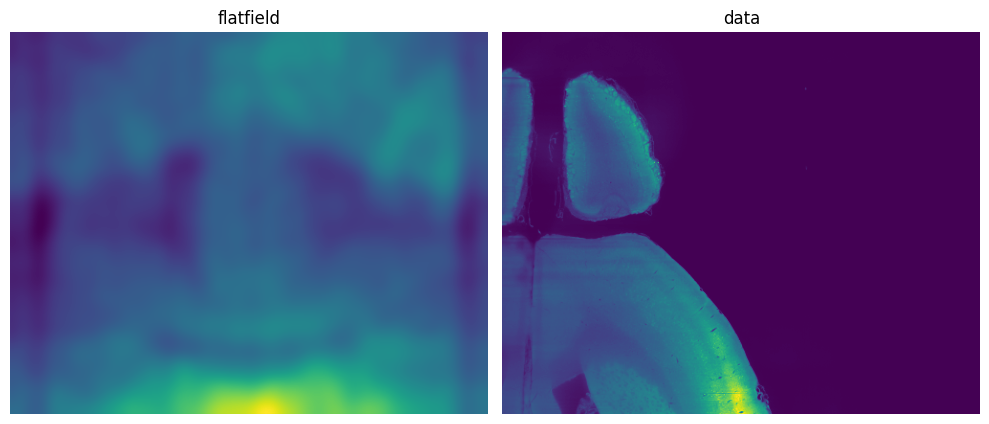

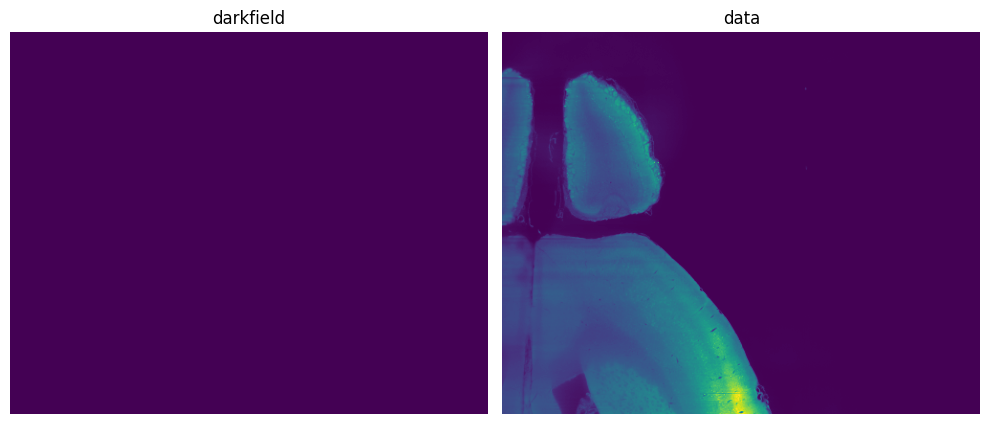

In [9]:
vis_img = slices[160][3]

darkfield = np.full(vis_img.shape, 105).astype(np.uint8)
shading_results['darkfield'] = darkfield

print(darkfield.shape, darkfield.dtype, vis_img.dtype)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Display images
# plt.suptitle("flatfield")
ax1.set_title('flatfield')
ax1.imshow(shading_results['flatfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title('data')
ax2.imshow(vis_img)
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# plt.suptitle("darkfield")

# Display images
ax1.set_title('darkfield')
ax1.imshow(shading_results['darkfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title('data')
ax2.imshow(vis_img)
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

(400, 500) uint8 uint16


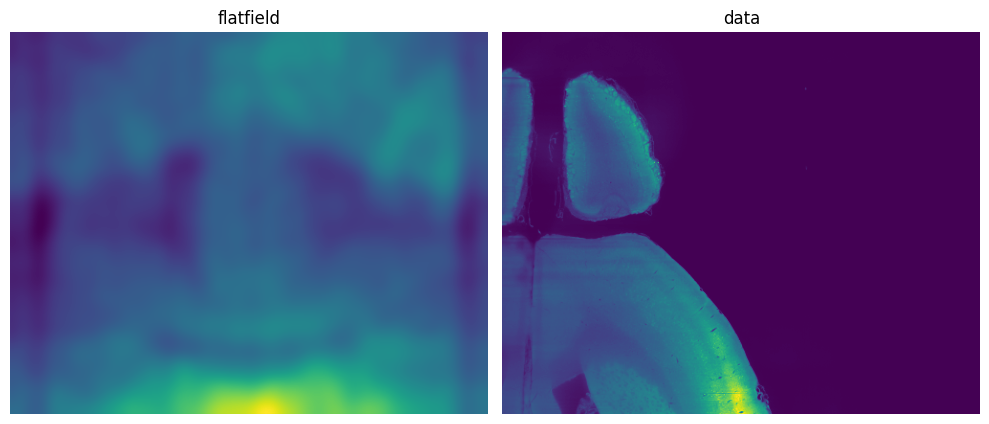

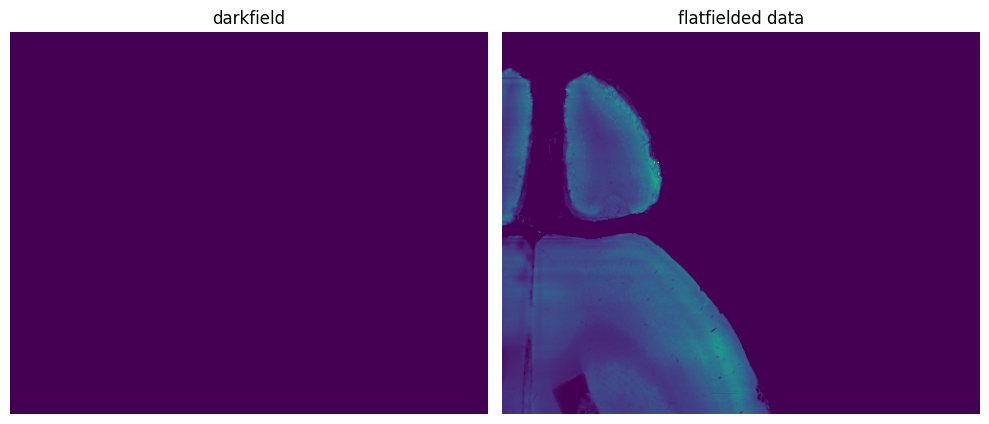

In [14]:
darkfield = np.full(corrected_vis_img.shape, 105).astype(np.uint8)

corrected_vis_img = flatfield_correction(
    image_tiles=vis_img,
    flatfield=shading_results['flatfield'],
    darkfield=shading_results['darkfield'],
)

shading_results['darkfield'] = darkfield
print(darkfield.shape, darkfield.dtype, corrected_vis_img.dtype)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Display images
# plt.suptitle("flatfield")
ax1.set_title('flatfield')
ax1.imshow(shading_results['flatfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title('data')
ax2.imshow(vis_img)
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# plt.suptitle("darkfield")

# Display images
ax1.set_title('darkfield')
ax1.imshow(shading_results['darkfield'])
ax1.axis('off')  # Turn off axis labels
ax2.set_title('flatfielded data')
ax2.imshow(corrected_vis_img)
ax2.axis('off')  # Turn off axis labels

# Adjust layout and show
plt.tight_layout()
plt.show()

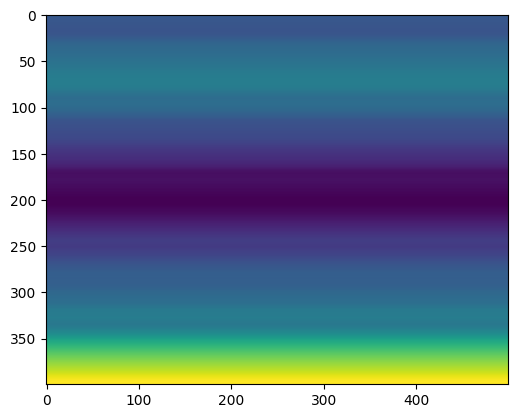

In [15]:
def create_median_flatfield(flatfield):
    median_row = np.median(flatfield, axis=1)
    median_image = np.tile(median_row[:, np.newaxis], (1, flatfield.shape[1]))
    return median_image

median_flatfield = create_median_flatfield(shading_results['flatfield'])

plt.imshow(median_flatfield)
plt.show()

In [16]:
np.mean(darkfield)

105.0

In [17]:
median_corrected_vis_img = flatfield_correction(
    vis_img,
    flatfield=median_flatfield,
    darkfield=darkfield,
    baseline = None,#baseline,
)

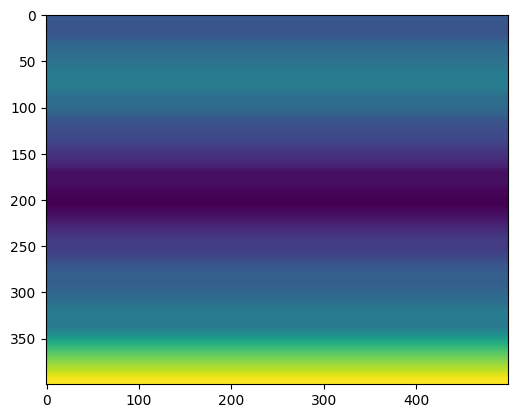

In [22]:
from scipy.ndimage import gaussian_filter

sigma = np.max(medi)

smooth_median_flatfield = gaussian_filter(median_flatfield, sigma=0.5)

plt.imshow(smooth_median_flatfield)
plt.show()

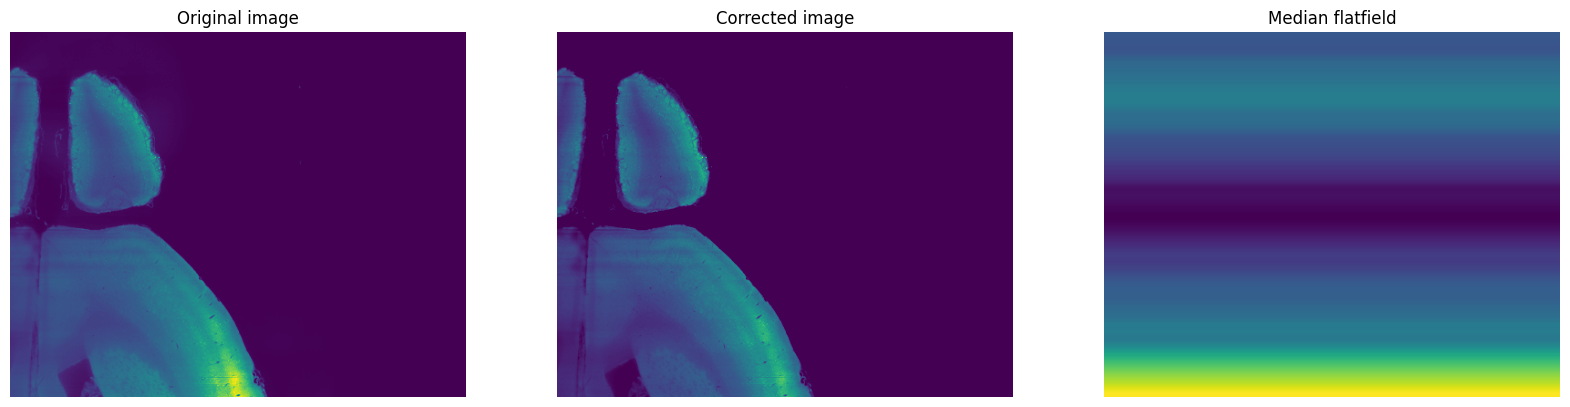

uint16 uint16


Text(0.5, 1.0, 'Corrected hist image')

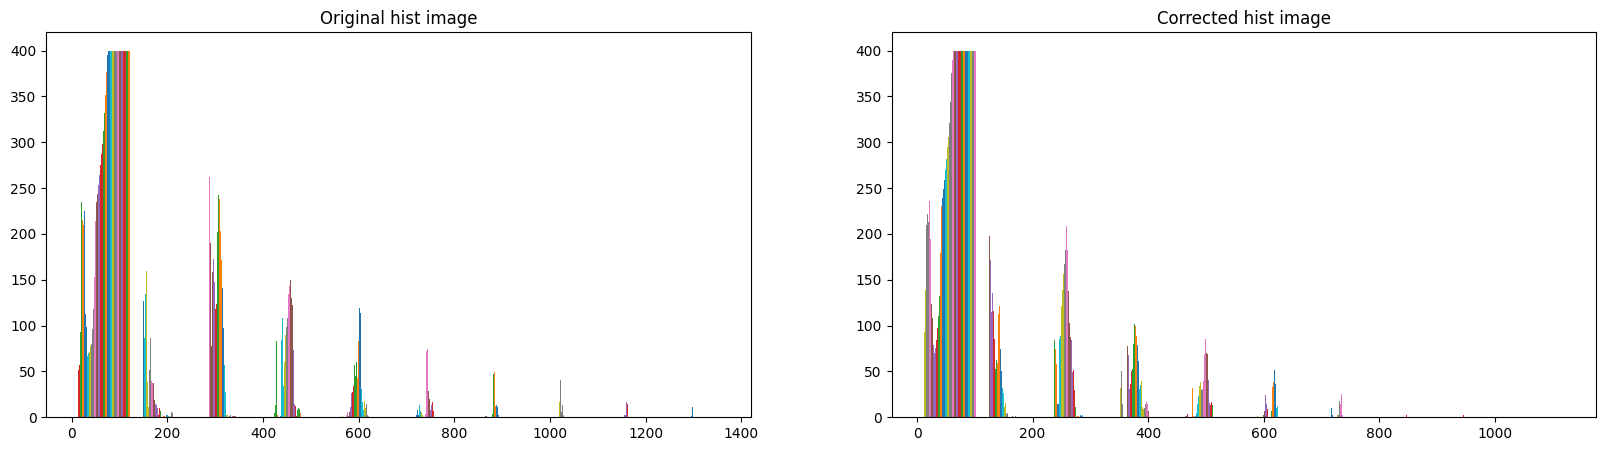

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
# Plot the first image
axs[0].imshow(vis_img)
axs[0].axis('off')  # Hide the axes
axs[0].set_title('Original image')

# Plot the second image
axs[1].imshow(median_corrected_vis_img)
axs[1].axis('off')  # Hide the axes
axs[1].set_title('Corrected image')

# Plot the third image
axs[2].imshow(median_flatfield)
axs[2].axis('off')  # Hide the axes
axs[2].set_title('Median flatfield')

# Display the plot
plt.show()

print(median_corrected_vis_img.dtype, vis_img.dtype)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
# Plot the first image
axs[0].hist(vis_img)
# axs[0].axis('off')  # Hide the axes
axs[0].set_title('Original hist image')

# Plot the second image
axs[1].hist(median_corrected_vis_img)
# axs[1].axis('off')  # Hide the axes
axs[1].set_title('Corrected hist image')

# Using only slices and then combining

In [7]:
slice_flats = []

shading_parameters = {
    "get_darkfield": False,
    "smoothness_flatfield": 1.0,
    "smoothness_darkfield": 20,
    "sort_intensity": True,
    "max_reweight_iterations": 35,
    "resize_mode":"skimage_dask"
}

flatfields = []
darkfields = []
baselines = []

for curr_slice in slices:
    print(curr_slice.shape)
    shading_results = shading_correction(
        slides=curr_slice, shading_parameters = shading_parameters
    )
    flatfields.append(shading_results['flatfield'])
    darkfields.append(shading_results['darkfield'])
    baselines.append(shading_results['baseline'])    

(6, 400, 500)


/tmp/ipykernel_897/1490229736.py:33: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  shading_obj.fit(images=np.array(slides), fitting_weight=mask)


(6, 400, 500)


/tmp/ipykernel_897/1490229736.py:33: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  shading_obj.fit(images=np.array(slides), fitting_weight=mask)


(6, 400, 500)
(6, 400, 500)
(6, 400, 500)


Reweighting did not converge.


(6, 400, 500)
(6, 400, 500)


Reweighting did not converge.


(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)
(6, 400, 500)


In [9]:
from typing import List, Optional

def unify_fields(
    flatfields: List[np.array],
    darkfields: List[np.array],
    baselines: List[np.array],
    mode: Optional[str] = "median",
):
    """
    Unifies the computed flatfields, darkfields and
    baselines using an statistical mode.

    Parameters
    ----------
    flatfields: List[np.array]
        List of computed flatfields per slide.

    darkfields: List[np.array]
        List of computed darkfields per slide.

    baselines: List[np.array]
        List of computed baselines per slide.

    mode: Optional[str]
        Statistical mode to combine flatfields,
        darkfields and baselines.

    Returns
    -------
    Tuple[np.array, np.array, np.array]
        Combined flatfield, darkfield and baseline.
    """
    flatfield = None
    darkfield = None
    baseline = None

    flatfields = np.array(flatfields)
    darkfields = np.array(darkfields)
    baselines = np.array(baselines)

    if mode == "median":
        flatfield = np.median(flatfields, axis=0)
        darkfield = np.median(darkfields, axis=0)
        baseline = np.median(baselines, axis=0)

    elif mode == "mean":
        flatfield = np.mean(flatfields, axis=0)
        darkfield = np.mean(darkfields, axis=0)
        baseline = np.mean(baselines, axis=0)

    elif mode == "mip":
        flatfield = np.max(flatfields, axis=0)
        darkfield = np.min(darkfields, axis=0)
        baseline = np.max(baselines, axis=0)

    else:
        raise NotImplementedError(f"Accepted values are: ['mean', 'median', 'mip']")

    flatfield = flatfield.astype(
        np.float16
    )  # np.clip(flatfield, 0, 65535).astype('uint16')
    darkfield = darkfield.astype(
        np.float16
    )  # np.clip(darkfield, 0, 65535).astype('uint16')
    baseline = baseline.astype(
        np.float16
    )  # np.clip(baseline, 0, 65535).astype('uint16')

    return flatfield, darkfield, baseline

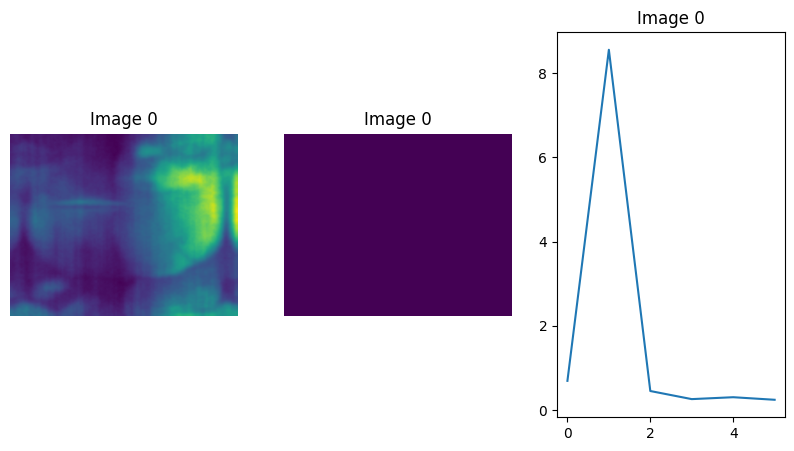

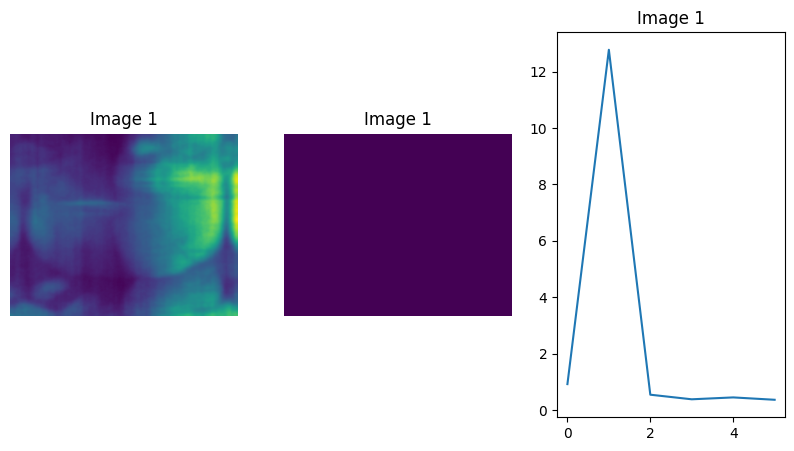

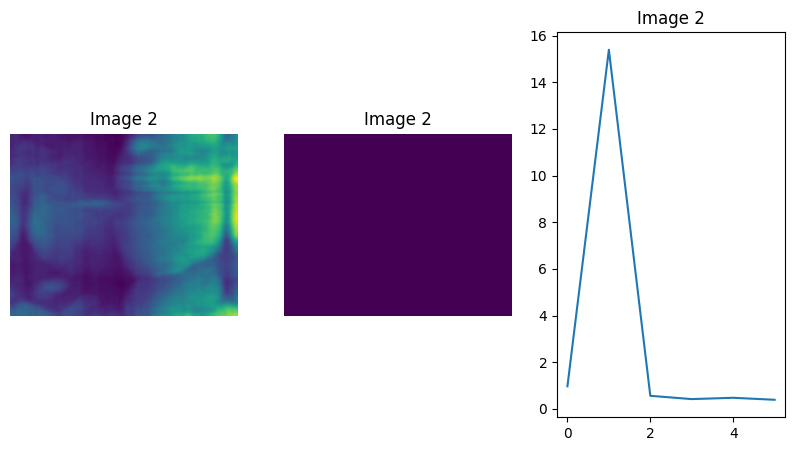

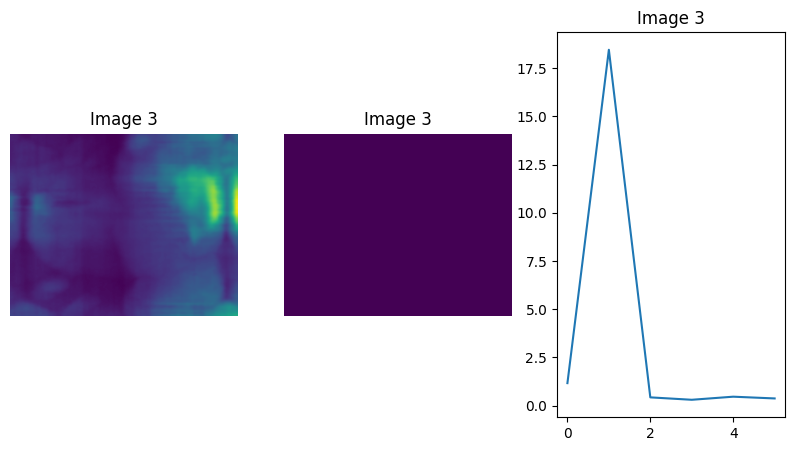

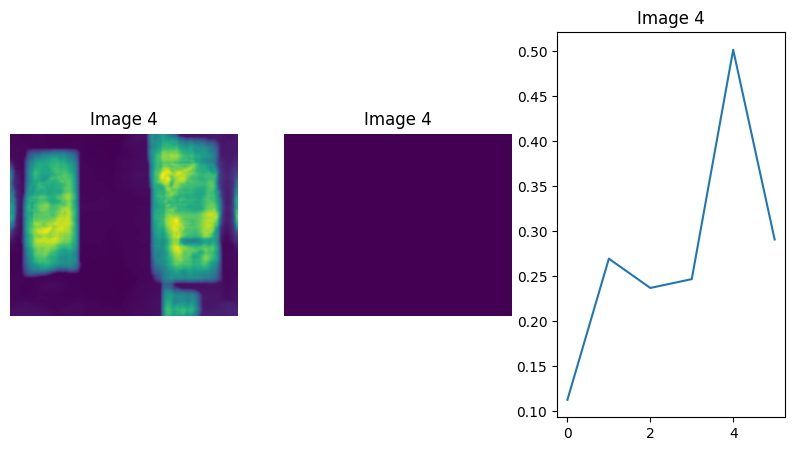

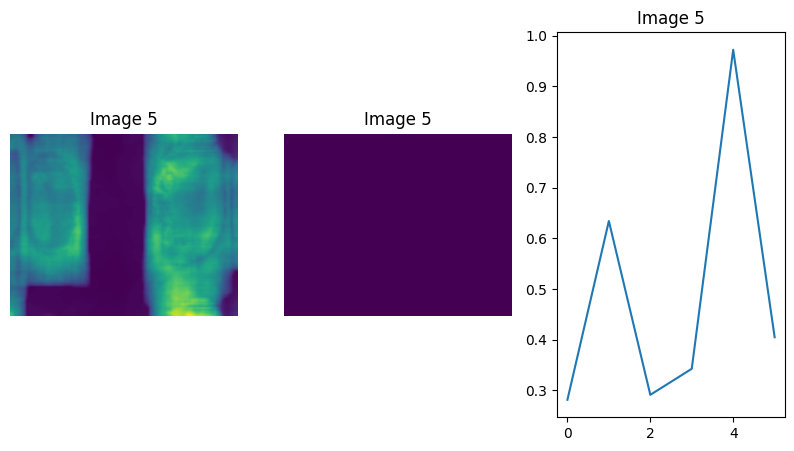

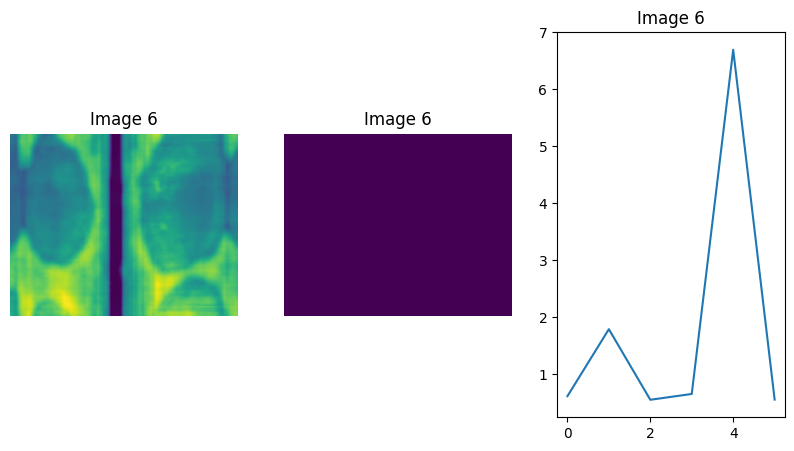

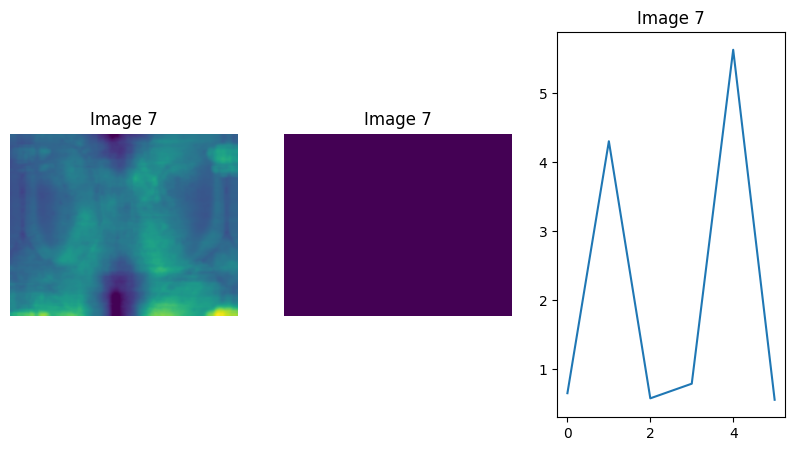

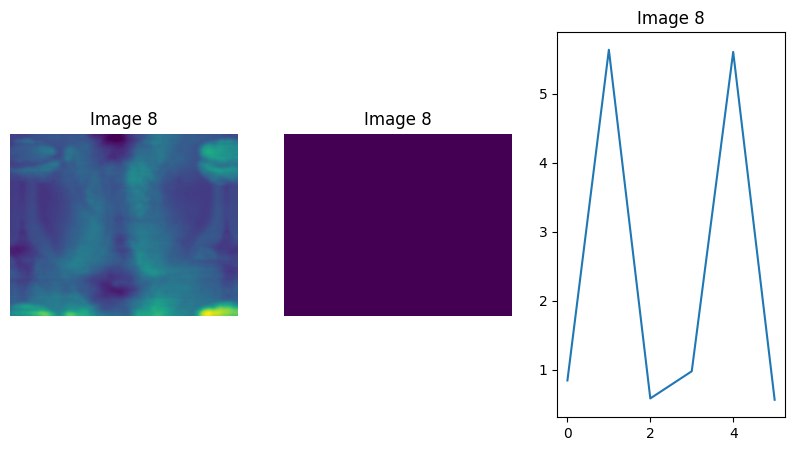

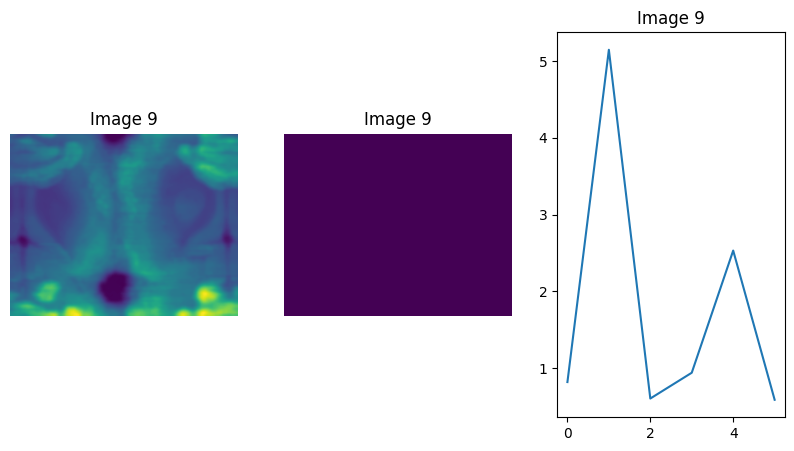

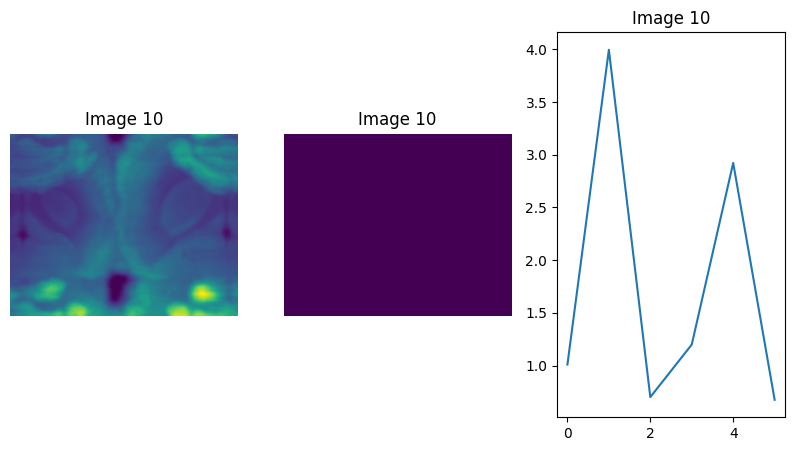

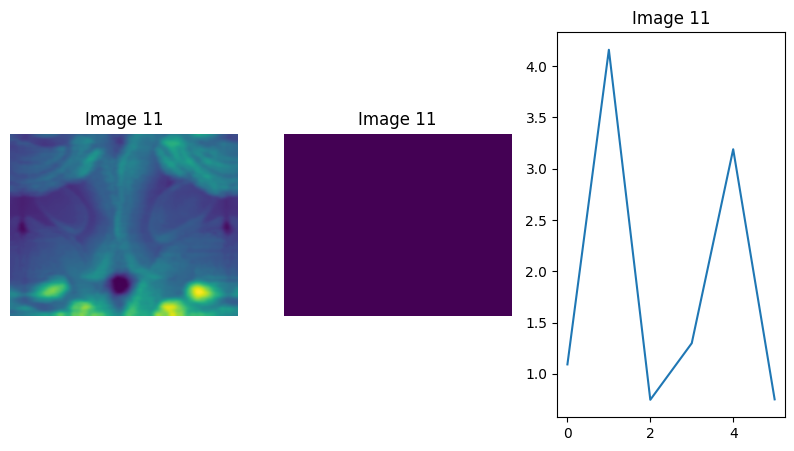

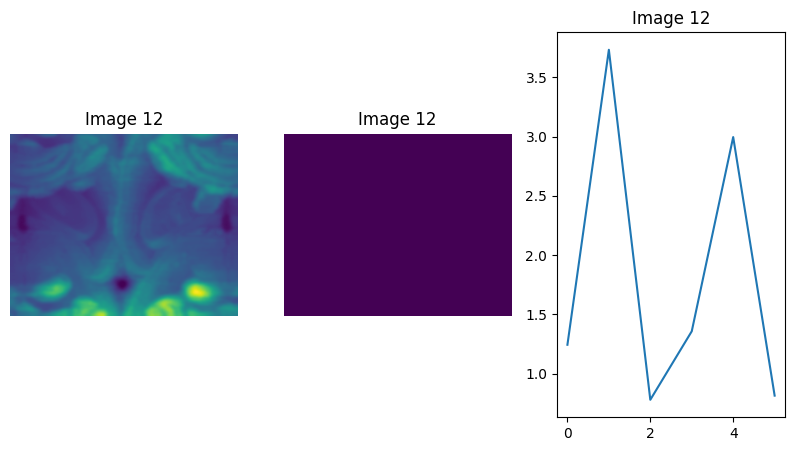

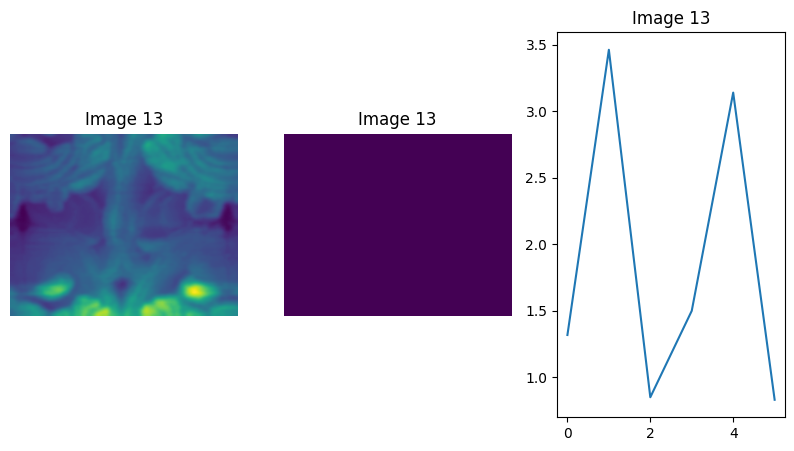

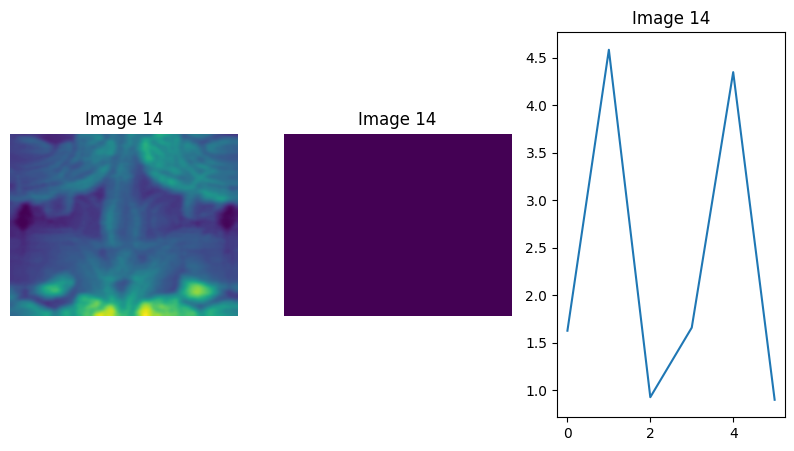

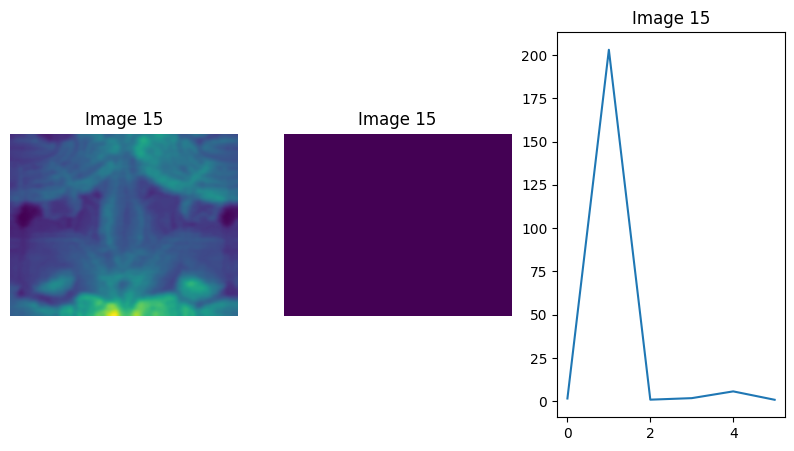

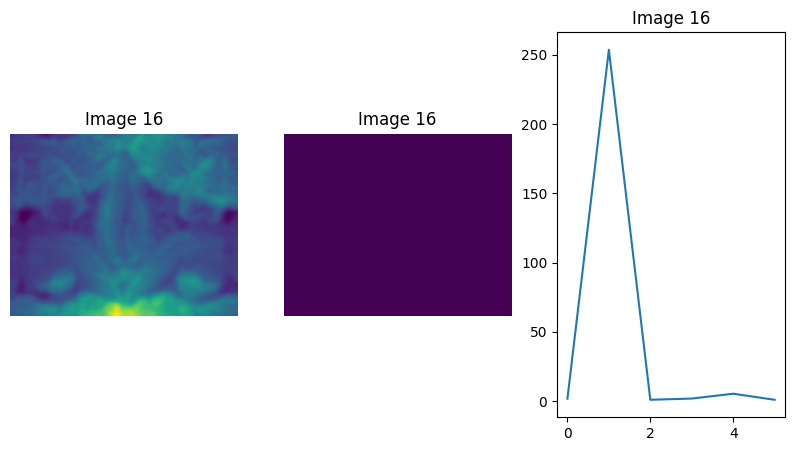

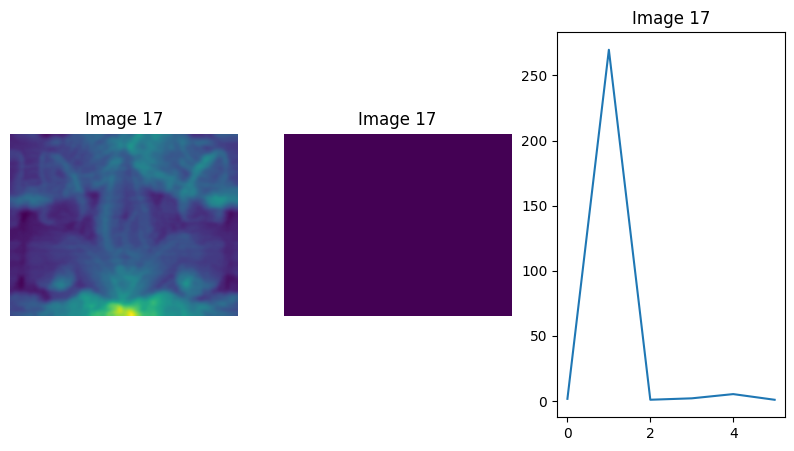

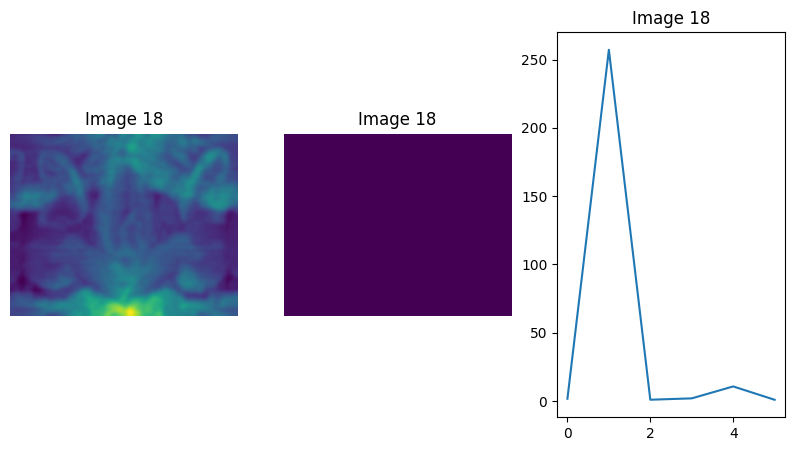

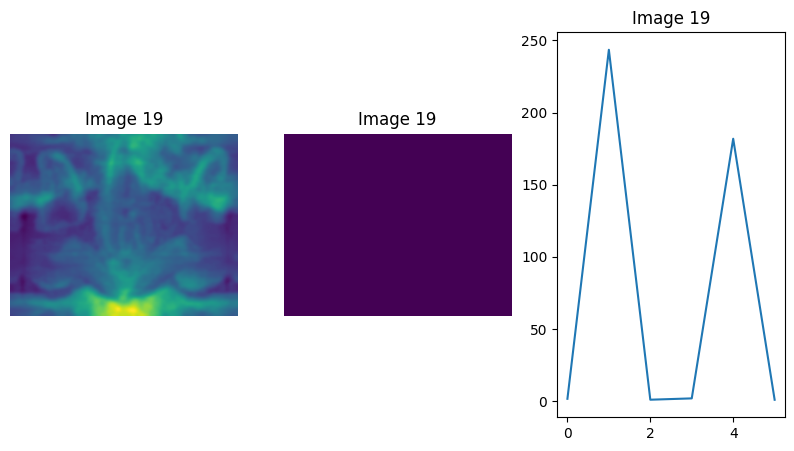

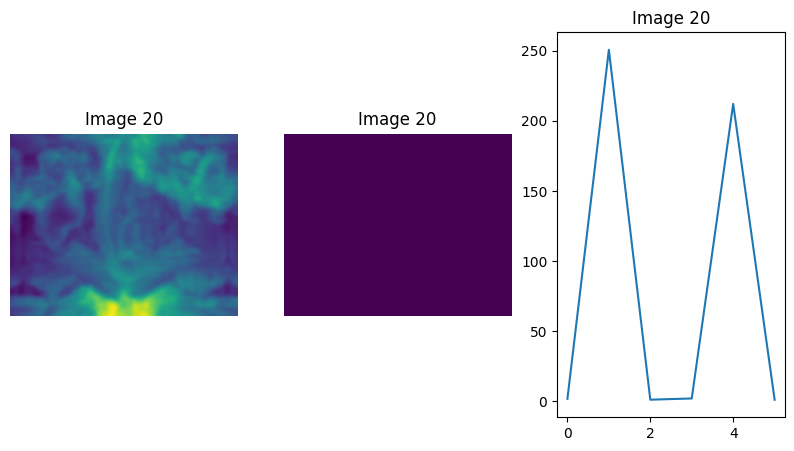

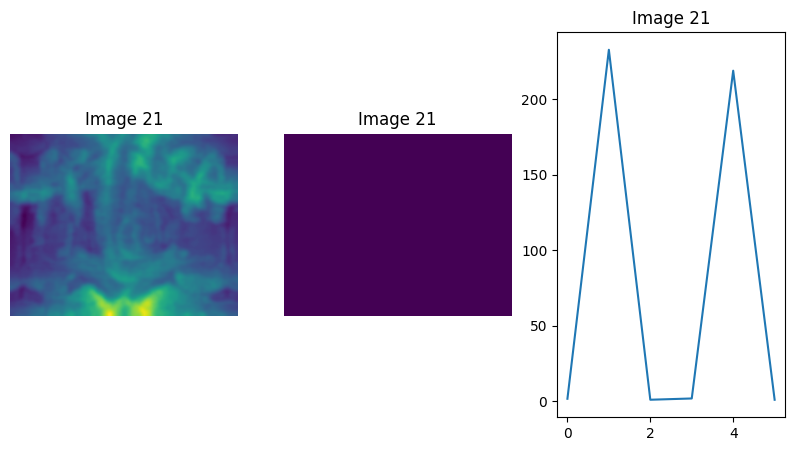

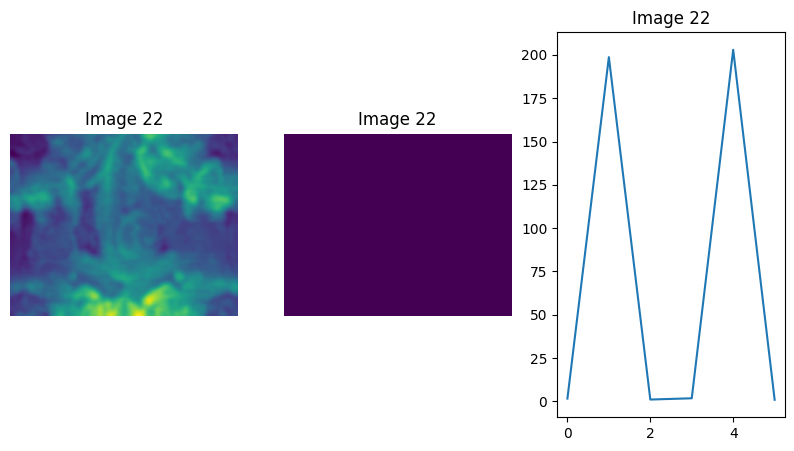

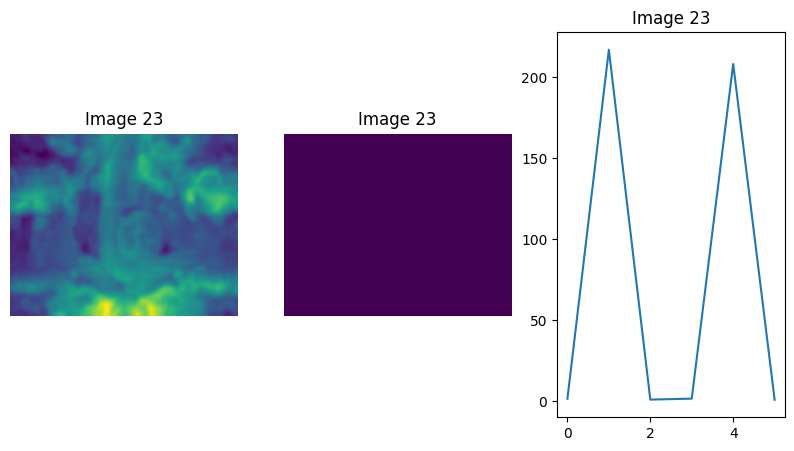

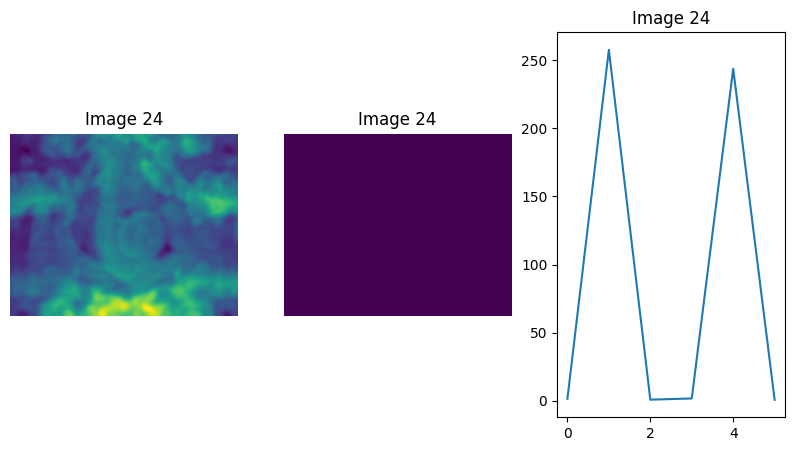

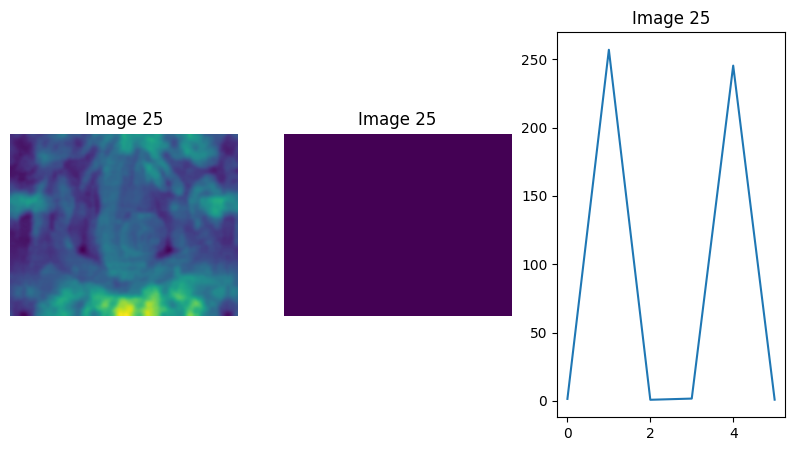

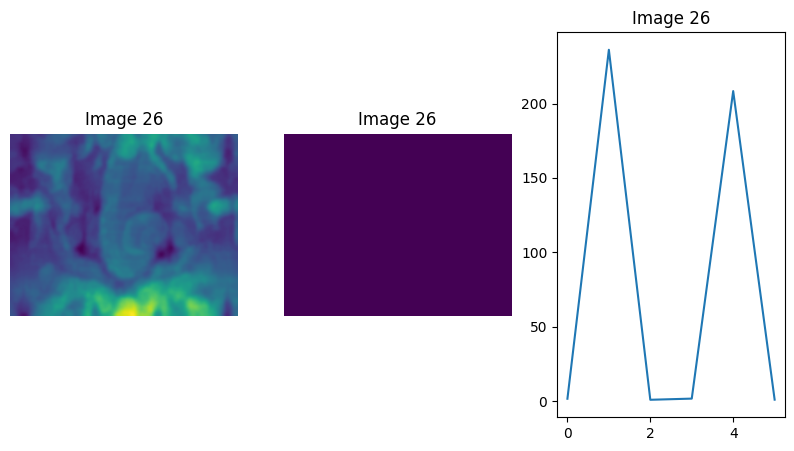

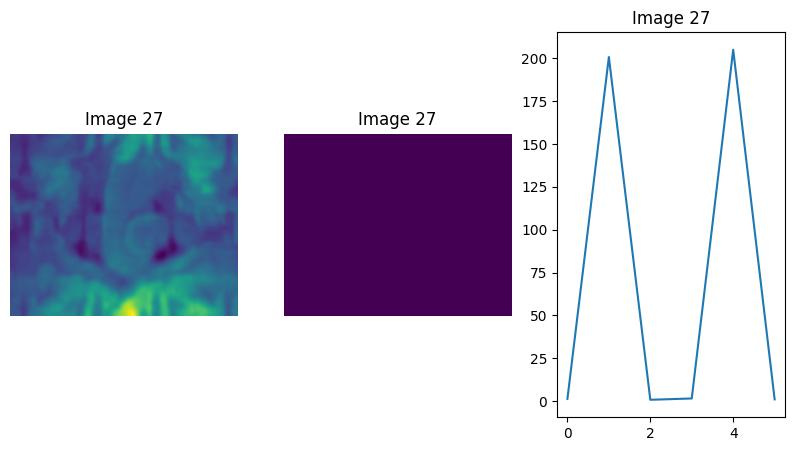

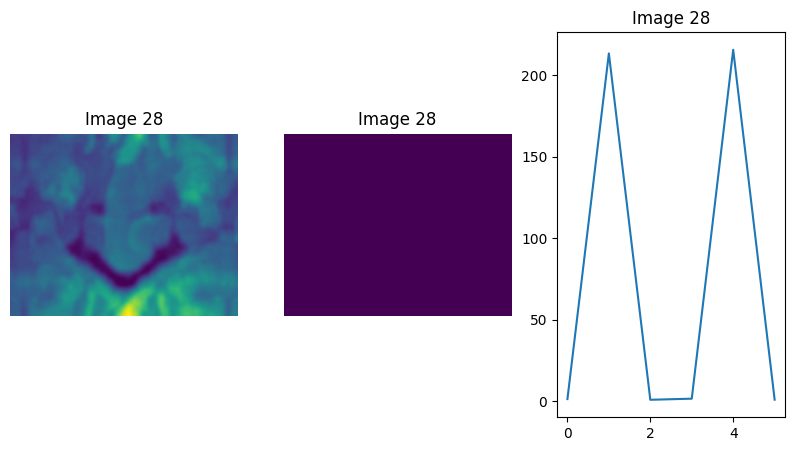

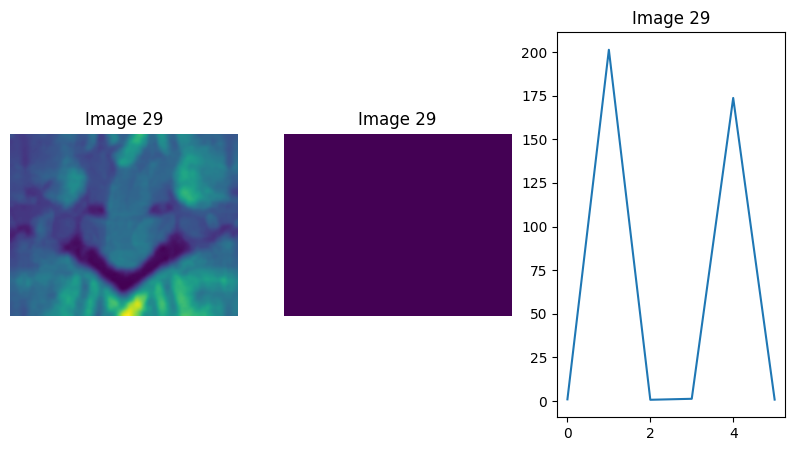

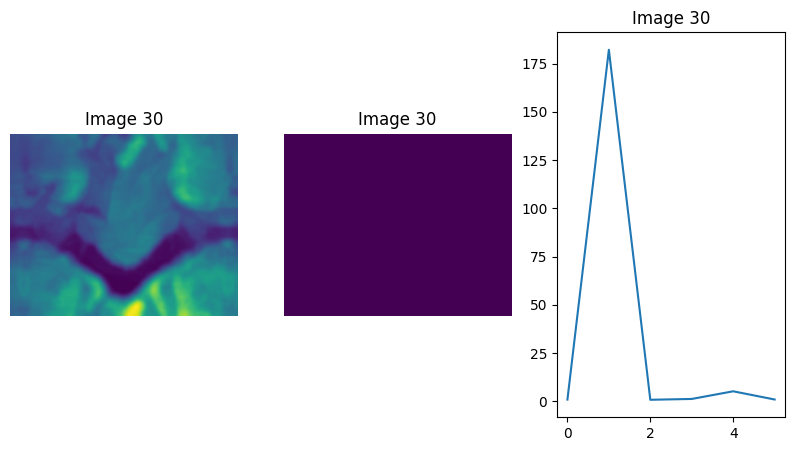

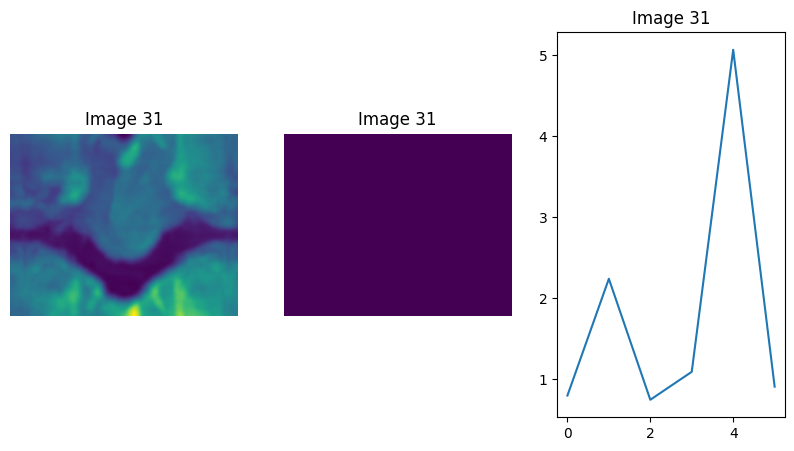

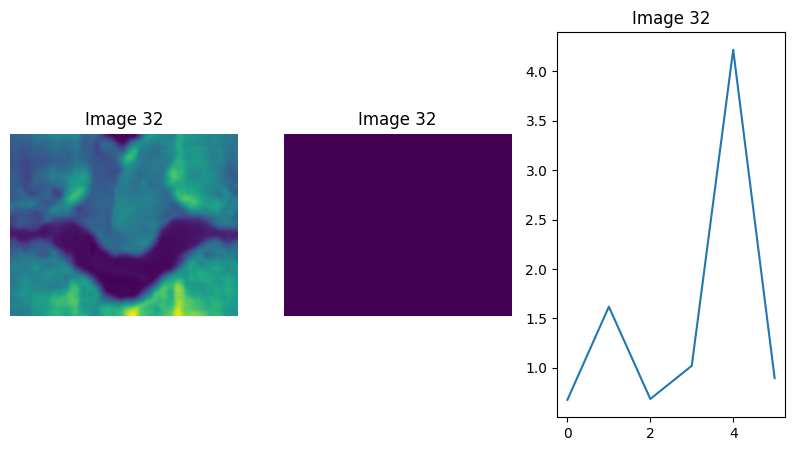

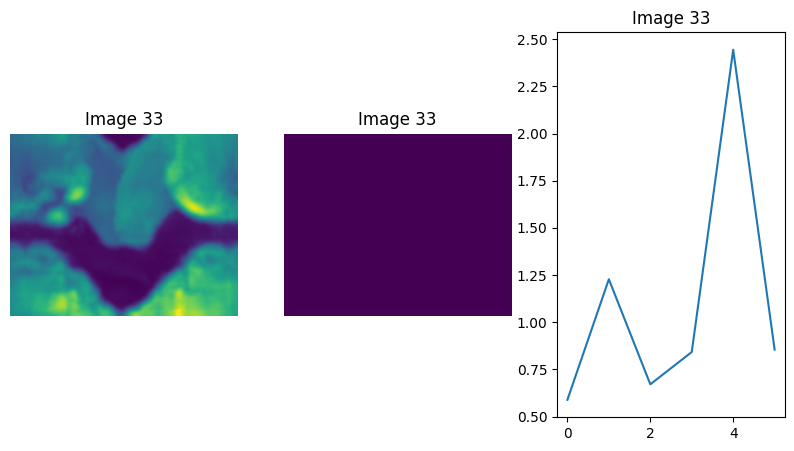

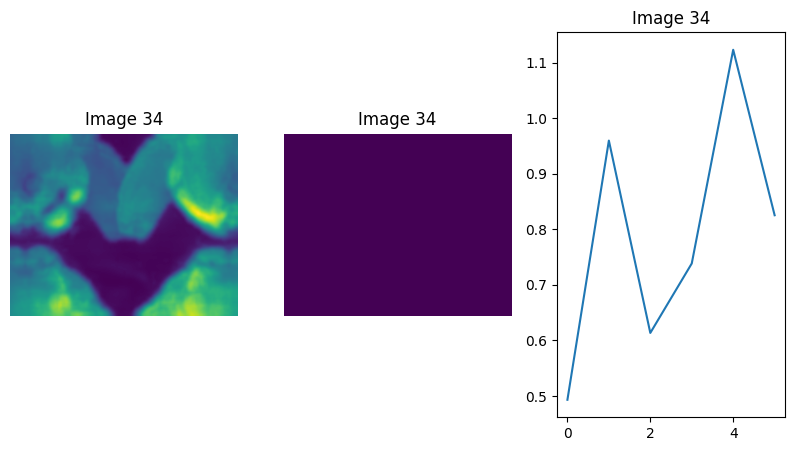

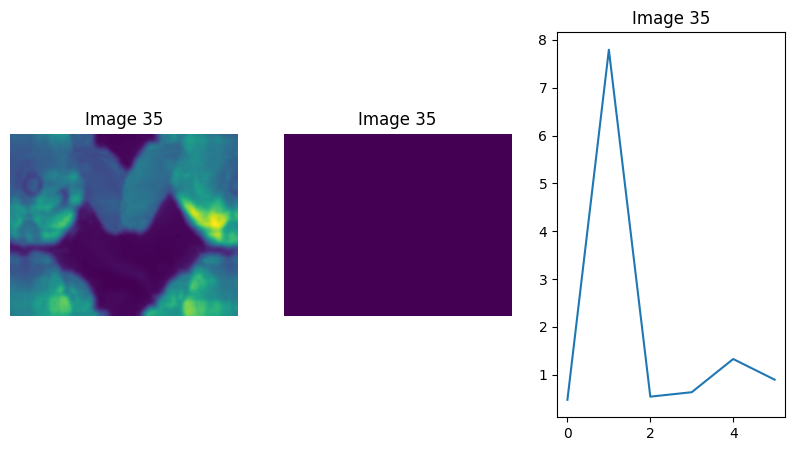

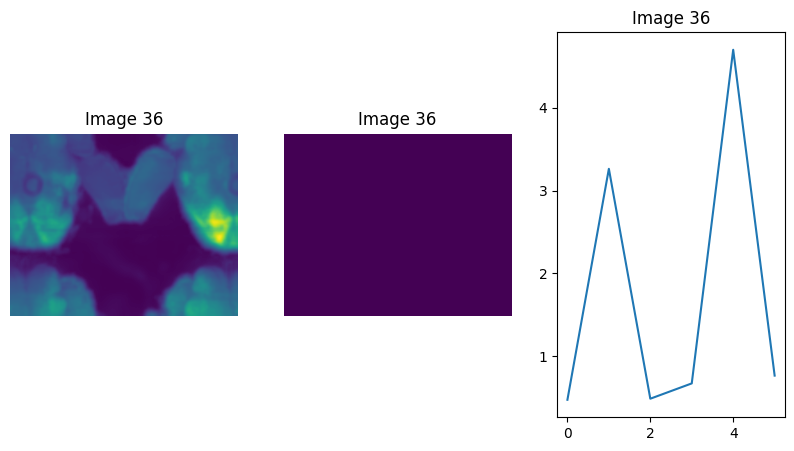

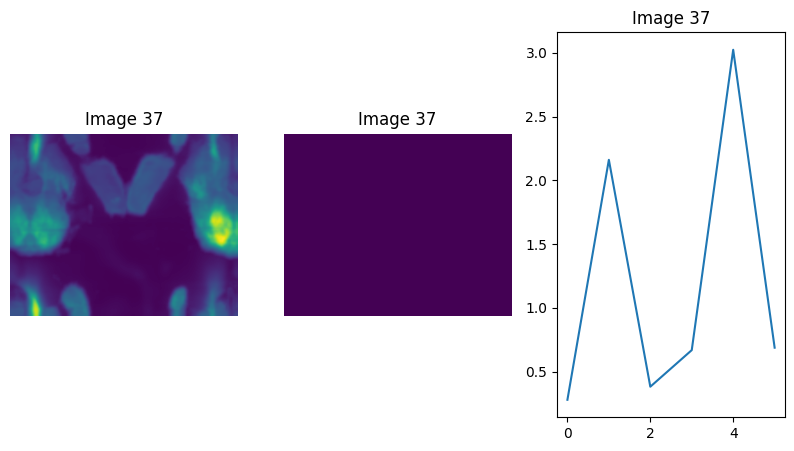

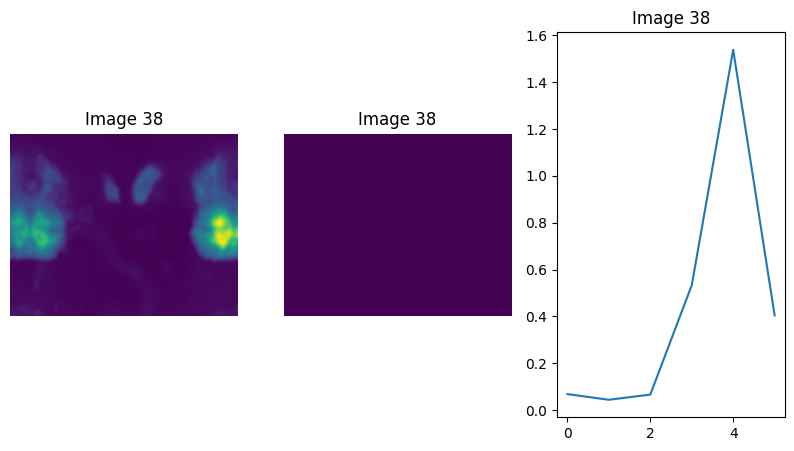

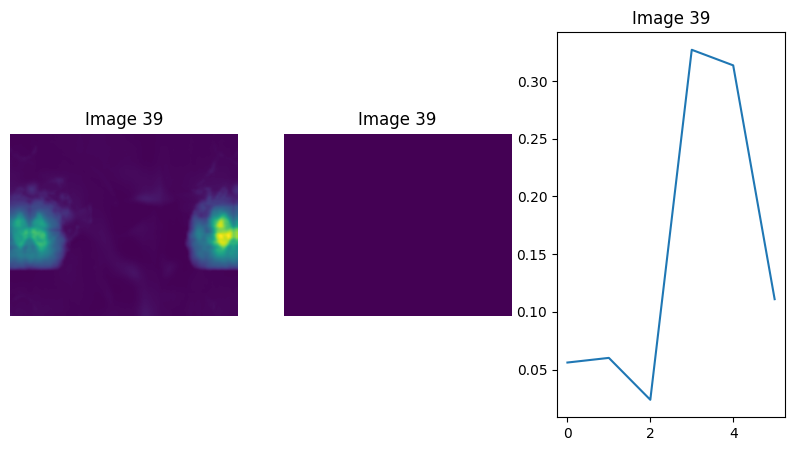

In [17]:
for idx in range(len(flatfields)):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    # Plot the first image
    axs[0].imshow(flatfields[idx])
    axs[0].axis('off')  # Hide the axes
    axs[0].set_title(f'Image {idx}')

    # Plot the second image
    axs[1].imshow(darkfields[idx])
    axs[1].axis('off')  # Hide the axes
    axs[1].set_title(f'Image {idx}')

    # Plot the third image
    axs[2].plot(baselines[idx])
#     axs[2].axis('off')  # Hide the axes
    axs[2].set_title(f'Image {idx}')

    # Display the plot
    plt.show()

In [22]:
flatfield, darkfield, baseline = unify_fields(
    flatfields=flatfields,
    darkfields=darkfields,
    baselines=baselines,
    mode = "median",
)

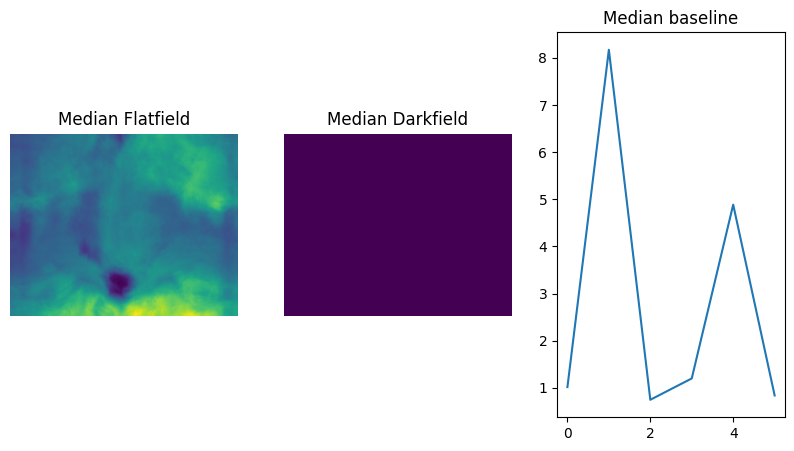

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Plot the first image
axs[0].imshow(flatfield)
axs[0].axis('off')  # Hide the axes
axs[0].set_title('Median Flatfield')

# Plot the second image
axs[1].imshow(darkfield)
axs[1].axis('off')  # Hide the axes
axs[1].set_title('Median Darkfield')

# Plot the third image
axs[2].plot(baseline)
#     axs[2].axis('off')  # Hide the axes
axs[2].set_title('Median baseline')

# Display the plot
plt.show()

In [32]:
def create_median_flatfield(flatfield):
    median_row = np.median(flatfield, axis=1)
    median_image = np.tile(median_row[:, np.newaxis], (1, flatfield.shape[1]))
    return median_image

median_flatfield = create_median_flatfield(flatfield)

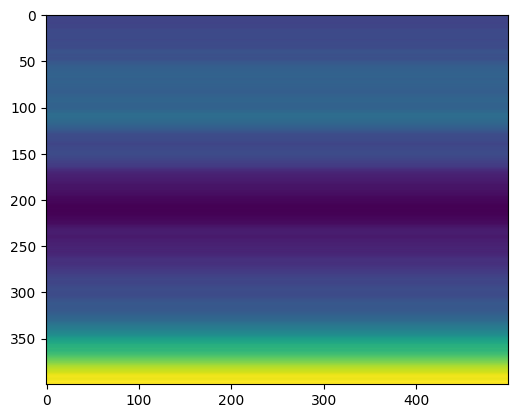

In [33]:
plt.imshow(median_flatfield)
plt.show()

In [34]:
print(np.mean(median_flatfield), np.mean(darkfield), np.mean(baseline))

0.9717 0.0 2.81


In [49]:
camera_darkfield = np.full(vis_img.shape, 105).astype(np.uint8)
median_corrected_vis_img = flatfield_correction(
    vis_img,
    flatfield=median_flatfield,
    darkfield=camera_darkfield,
    baseline = None,#baseline,
)

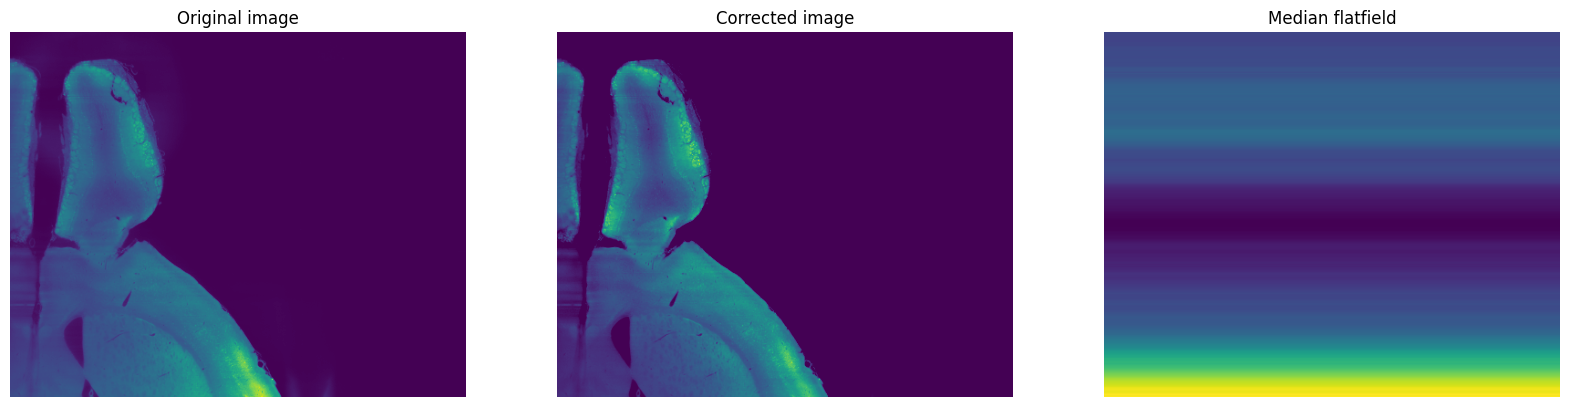

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
# Plot the first image
axs[0].imshow(vis_img)
axs[0].axis('off')  # Hide the axes
axs[0].set_title('Original image')

# Plot the second image
axs[1].imshow(median_corrected_vis_img)
axs[1].axis('off')  # Hide the axes
axs[1].set_title('Corrected image')

# Plot the third image
axs[2].imshow(median_flatfield)
axs[2].axis('off')  # Hide the axes
axs[2].set_title('Median flatfield')

# Display the plot
plt.show()

uint16 uint16


Text(0.5, 1.0, 'Corrected hist image')

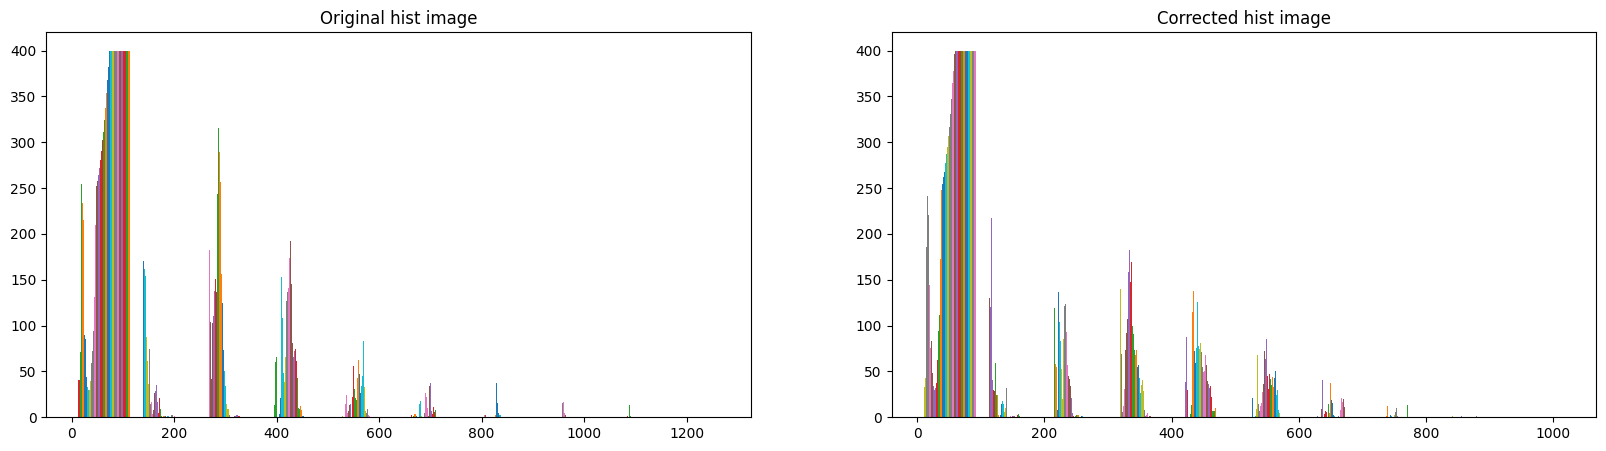

In [43]:
print(median_corrected_vis_img.dtype, vis_img.dtype)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
# Plot the first image
axs[0].hist(vis_img)
# axs[0].axis('off')  # Hide the axes
axs[0].set_title('Original hist image')

# Plot the second image
axs[1].hist(median_corrected_vis_img)
# axs[1].axis('off')  # Hide the axes
axs[1].set_title('Corrected hist image')

In [44]:
np.save("/results/median_corrected.npy", median_corrected_vis_img)
np.save("/results/orig_img.npy", vis_img)

In [46]:
import tifffile
tifffile.imwrite("/results/median_corrected.tif", median_corrected_vis_img)
tifffile.imwrite("/results/orig_img.tif", vis_img)

# Estimating flats per laser

In [1]:
import json
from pathlib import Path
import os

from pathlib import Path
from natsort import natsorted
import os
import dask.array as da

from pathlib import Path
from natsort import natsorted

import matplotlib.pyplot as plt
import numpy as np

def show_grid(images:list, names:list, n_rows, n_cols, slide_idx, show_tile_name=False) -> None:
    print("Plotting")
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
    fig.suptitle(f"Slide {slide_idx} - SmartSPIM dataset")
    row_idx = 0
    col_idx = 0
    
    vmin, vmax = np.percentile(images[len(images)//2].flatten(), (0.2, 99.9))   
    print("vmin vmax ",vmin, vmax)

    for img_idx in range(len(images)):
#         print(row_idx, col_idx)
        axs[row_idx][col_idx].imshow(images[img_idx], cmap='gray', vmin=vmin, vmax=vmax)
        
        if show_tile_name:
            #axs[row_idx][col_idx].set_title(names[img_idx], fontsize=8)
            
            if row_idx == 0:
                col = names[img_idx].split("/")[0]
                axs[row_idx][col_idx].set_title(col, fontsize=10)
            
            if col_idx == 0:
                row = names[img_idx].split("_")[-1]
                axs[row_idx][col_idx].set_ylabel(row, fontsize=10)
                
        row_idx += 1

        if row_idx == n_rows:
            row_idx = 0
            col_idx += 1
    
    plt.tight_layout()
    plt.show()

def plot_slide(dataset_path, cols, rows, slide_idx, scale=0, show_tile_name=False):
    
    n_rows = len(rows)
    n_cols = len(cols)
    
    imgs = []
    names = []
    print(f"Getting images from slide {slide_idx}")
    for col in cols:
        for row in rows:
            zarr_path = dataset_path.joinpath(f"{col}_{row}.zarr/{scale}")
            print(f"Reading {zarr_path}")
            imgs.append(
                da.from_zarr(zarr_path)[0, 0, slide_idx, ...].compute()
#                 img_stack[row_col][slide_idx, :, :]
            )
            names.append(
                f"{col}_{row}.zarr"
            )
    
    show_grid(imgs, names, n_rows, n_cols, slide_idx, show_tile_name)

def get_brain_slices(dataset_path, cols, rows, slide_idx, scale=0, show=False):
    imgs = []
    names = []
    n_rows = len(rows)
    n_cols = len(cols)
    
    for col in cols:
        for row in rows:
            zarr_path = dataset_path.joinpath(f"{col}_{row}.zarr/{scale}")
            lazy_tile = da.from_zarr(zarr_path)[0, 0, slide_idx, ...]
#             print(f"Worker {os.getpid()} reading {zarr_path} - slide {slide_idx}\n")
            imgs.append(
                lazy_tile.compute()
            )
            names.append(
                f"{col}_{row}.zarr"
            )
    
    if show:
        show_grid(imgs, names, n_rows, n_cols, slide_idx, True)
    
    return np.array(imgs), names

def pick_slices(image_stack, percentage, read_lazy=True):
    """
    Pick slices from a 3D image stack based on a given percentage.
    
    Args:
    - image_stack: 3D numpy array representing the image stack (Z, Y, X).
    - percentage: Percentage of the Z stack to pick (between 0 and 1).
    
    Returns:
    - picked_slices: List of slices picked from the image stack.
    """
    z_dim = image_stack.shape[-3]
    print("Z dim: ", z_dim, image_stack.shape)
    num_slices_to_pick = int(np.floor(percentage * z_dim))
    
    if num_slices_to_pick == 0:
        raise ValueError("Percentage too low to pick any slices.")
    
    step_size = z_dim // num_slices_to_pick
    
    slices = list(range(0, z_dim, step_size))
    
    picked_slices = None
    if read_lazy:
        picked_slices = [image_stack[i] for i in slices]
        picked_slices = da.stack(picked_slices)
    
    return picked_slices, slices

def read_json_as_dict(filepath: str) -> dict:
    """
    Reads a json as dictionary.
    Parameters
    ------------------------
    filepath: PathLike
        Path where the json is located.
    Returns
    ------------------------
    dict:
        Dictionary with the data the json has.
    """

    dictionary = {}

    if os.path.exists(filepath):
        try:
            with open(filepath) as json_file:
                dictionary = json.load(json_file)

        except UnicodeDecodeError:
            print("Error reading json with utf-8, trying different approach")
            # This might lose data, verify with Jeff the json encoding
            with open(filepath, "rb") as json_file:
                data = json_file.read()
                data_str = data.decode("utf-8", errors="ignore")
                dictionary = json.loads(data_str)

    #             print(f"Reading {filepath} forced: {dictionary}")

    return dictionary

def get_col_rows_per_laser(derivatives_folder):
    derivatives_folder = Path(derivatives_folder)
    metadata_json_path = derivatives_folder.joinpath("metadata.json")
    
    laser_side = {}
    matadata_json = read_json_as_dict(metadata_json_path)
    tile_config = matadata_json.get('tile_config')
    
    if metadata_json_path.exists() and tile_config is not None:
        for time, config in tile_config.items():
            
            if config['Side'] not in laser_side:
                laser_side[config['Side']] = set()
            
            col_row = f"{config['X']}_{config['Y']}"
            
            laser_side[config['Side']].add(
                col_row
            )
    else:
        raise ValueError(f"Please check the metadata path: {metadata_json_path} and the content of the file!")

    return laser_side

laser_side = get_col_rows_per_laser(derivatives_folder="/data/SmartSPIM_717381_2024-07-03_10-49-01/derivatives")

Error reading json with utf-8, trying different approach


In [2]:
laser_side

{'0': {'422310_310380', '422310_367980', '422310_425580'},
 '1': {'494310_310380', '494310_367980', '494310_425580'}}

In [3]:
def get_slicer_per_side(tiles_per_laser, data_folder, indices, scale=2):

    data_per_laser = {k:[] for k in tiles_per_laser.keys()}
    cols = set()
    rows = set()
    data_folder = Path(data_folder)
    
    for folder in data_folder.glob("*.zarr"):
        if folder.suffix == ".zarr":
            col, row = str(folder.stem).split('_')
            cols.add(col)
            rows.add(row)

    cols = natsorted(cols)
    rows = natsorted(rows)
    
#     for side, tiles in tiles_per_laser.items():
#         print(f"Side {side} tiles: {tiles}")
#         if side not in data_per_laser:
#             data_per_laser[side] = []
        
    for indice in indices:
        params = {
            "dataset_path": data_folder,
            "cols": cols,
            "rows": rows,
            "slide_idx": indice,
            "scale": scale
        }

        curr_slcs, curr_nms = get_brain_slices(**params)

        for nm_idx in range(len(curr_nms)):
            curr_nm = curr_nms[nm_idx]
            curr_slc = curr_slcs[nm_idx]

            curr_nm = curr_nm.replace('.zarr', '')

            if curr_nm in tiles_per_laser['0']:
                data_per_laser['0'].append(curr_slc)
            
            elif curr_nm in tiles_per_laser['1']:
                data_per_laser['1'].append(curr_slc)
                
            else:
                raise ValueError(f'Stack {curr_nm} not in the metadata')
    
    for side, arr in data_per_laser.items():
        data_per_laser[side] = np.array(data_per_laser[side])
    
    return data_per_laser

In [4]:
import dask.array as da
from natsort import natsorted
data_folder = Path("/data/SmartSPIM_717381_2024-07-03_10-49-01-zarr-destriped-channels/Ex_488_Em_525")    

scale = 2

test_dir = list(data_folder.glob("*.zarr"))[0].joinpath(str(scale))
print("Test dir: ", test_dir)
lazy_data = da.from_zarr(test_dir)

cols = set()
rows = set()
for folder in data_folder.glob("*.zarr"):
    if folder.suffix == ".zarr":
        col, row = str(folder.stem).split('_')
        cols.add(col)
        rows.add(row)

cols = natsorted(cols)
rows = natsorted(rows)

picked_slices, indices = pick_slices(lazy_data, percentage=0.1, read_lazy=False)
slices_side_0 = []
names_side_0 = []
slices_side_1 = []
names_side_1 = []

print(f"Len indices: {len(indices)} {indices}")

tiles_per_side = get_slicer_per_side(
    tiles_per_laser=laser_side,
    data_folder=data_folder,
    indices=indices,
    scale=2
)

Test dir:  /data/SmartSPIM_717381_2024-07-03_10-49-01-zarr-destriped-channels/Ex_488_Em_525/422310_425580.zarr/2
Z dim:  784 (1, 1, 784, 400, 500)
Len indices: 79 [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780]


In [5]:
print(f"Slices side 0: {tiles_per_side['0'].shape} - Slices side 1: {tiles_per_side['1'].shape}")

Slices side 0: (237, 400, 500) - Slices side 1: (237, 400, 500)


In [6]:
# print(f"Names from side 0: {names_side_0}")
# print(f"Names from side 1: {names_side_1}")

In [7]:
from basicpy import BaSiC

def shading_correction(
    slides, shading_parameters: dict, mask = None
):
    """
    Computes shading correction for each of the
    provided tiles for further post-processing.

    Parameters
    ----------
    slides: List[List[ArrayLike]]
        List of tiles per slide used to compute
        the shading fitting.

    shading_parameters: dict
        Parameters to build the basicpy object

    mask: ArrayLike
        Mask with weights for each of the pixels
        that determines the contribution of the fields
        to remove the shadows.

    Returns
    -------
    Tuple[Dict]
        tuple with the flatfield, darkfield and
        baseline results from the shadow fitting
        for further post-processing.
    """
    shading_obj = BaSiC(**shading_parameters)
    shading_results = []
    shading_obj.fit(images=np.array(slides), fitting_weight=mask)
    shading_results = {
        "flatfield": shading_obj.flatfield,
        "darkfield": shading_obj.darkfield,
        "baseline": shading_obj.baseline,
    }

    return shading_results

def flatfield_correction(
    image_tiles,
    flatfield: np.array,
    darkfield: np.array,
    baseline = None,
) -> np.array:
    """
    Corrects smartspim shadows in the tiles generated
    at the SmartSPIM light-sheet microscope.

    Parameters
    ----------
    image_tiles: List[np.array]
        Image tiles that will be corrected

    flatfield: np.array
        Estimated flatfield

    darkfield: np.array
        Estimated darkfield

    baseline: np.array
        Estimated baseline.
        Default: None

    Returns
    -------
    np.array
        Corrected tiles
    """

    image_tiles = np.array(image_tiles)

    if image_tiles.ndim != flatfield.ndim:
        flatfield = np.expand_dims(flatfield, axis=0)

    if image_tiles.ndim != darkfield.ndim:
        darkfield = np.expand_dims(darkfield, axis=0)

    darkfield = darkfield[: image_tiles.shape[-2], : image_tiles.shape[-1]]

    if darkfield.shape != image_tiles.shape:
        raise ValueError(
            f"Please, check the shape of the darkfield. Image shape: {image_tiles.shape} - Darkfield shape: {darkfield.shape}"
        )

    if flatfield.shape != image_tiles.shape:
        raise ValueError(
            f"Please, check the shape of the flatfield. Image shape: {image_tiles.shape} - Flatfield shape: {flatfield.shape}"
        )

    if baseline is None:
        baseline = np.zeros((image_tiles.shape[0],))

    baseline_indxs = tuple([slice(None)] + ([np.newaxis] * (image_tiles.ndim - 1)))

    # Subtracting dark field
    negative_darkfield = np.where(image_tiles <= darkfield)
    positive_darkfield = np.where(image_tiles > darkfield)

    # subtracting darkfield
    image_tiles[negative_darkfield] = 0
    image_tiles[positive_darkfield] = (
        image_tiles[positive_darkfield] - darkfield[positive_darkfield]
    )

    # Applying flatfield
    corrected_tiles = image_tiles / flatfield - baseline[baseline_indxs]

    # Converting back to uint16
    corrected_tiles = np.clip(corrected_tiles, 0, 65535).astype("uint16")

    return corrected_tiles

In [8]:
%%time

slice_flats = []

shading_parameters = {
    "get_darkfield": False,
    "smoothness_flatfield": 1.0,
    "smoothness_darkfield": 20,
    "sort_intensity": True,
    "max_reweight_iterations": 35,
    "resize_mode":"skimage_dask"
}

def estimate_flats_per_laser(tiles_per_side, shading_params):
    flats = {key: None for key in tiles_per_side.keys()}
    for side, tiles in tiles_per_side.items():
        
        print(f"Estimating flats for side {side}")
        flats[side] = shading_correction(
            slides=tiles, shading_parameters=shading_params
        )
    
    return flats

flats = estimate_flats_per_laser(
    tiles_per_side=tiles_per_side,
    shading_params=shading_parameters
)

Estimating flats for side 0


/tmp/ipykernel_994/2062042745.py:33: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  shading_obj.fit(images=np.array(slides), fitting_weight=mask)
Single-step optimization did not converge at the last reweighting step.


Estimating flats for side 1


/tmp/ipykernel_994/2062042745.py:33: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  shading_obj.fit(images=np.array(slides), fitting_weight=mask)
Reweighting did not converge.
Single-step optimization did not converge at the last reweighting step.


CPU times: user 19min 38s, sys: 15.7 s, total: 19min 53s
Wall time: 9min 21s


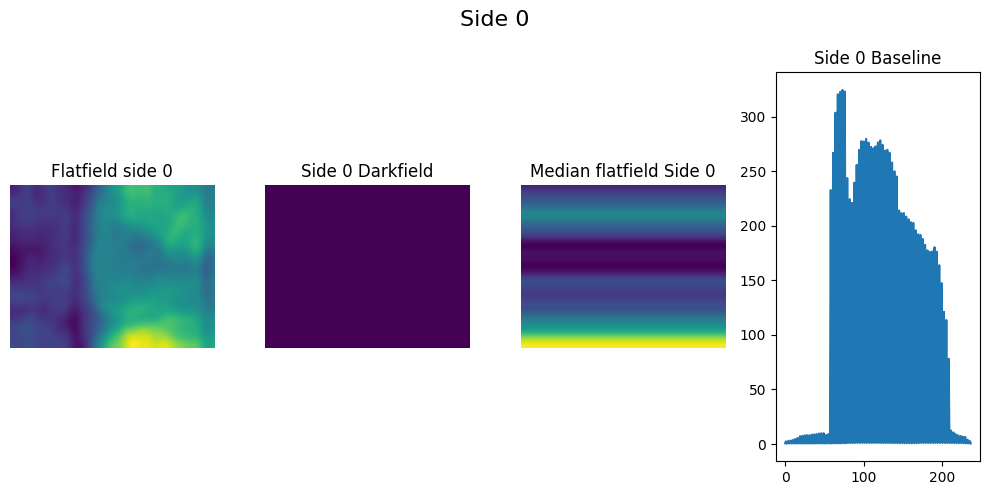

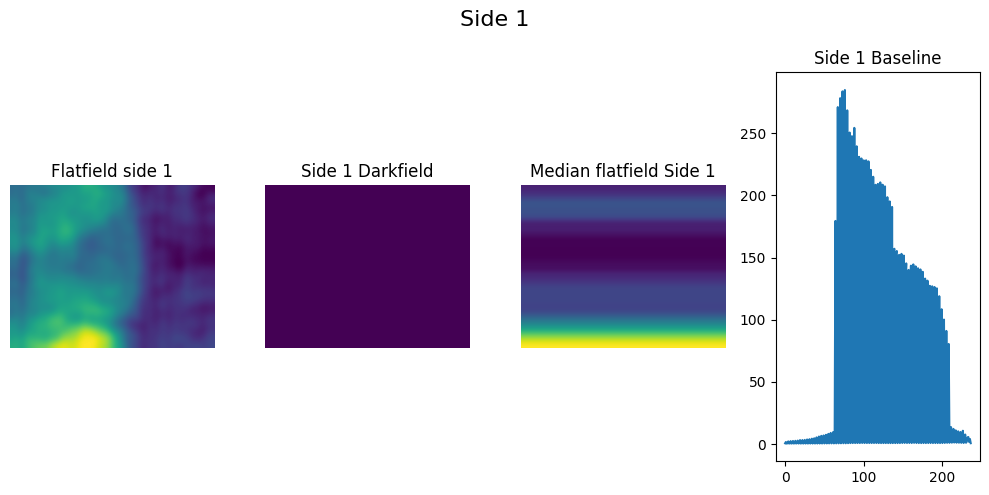

In [9]:
%matplotlib inline

from scipy.ndimage import gaussian_filter

def create_median_flatfield(flatfield, smooth=True):
    median_row = np.median(flatfield, axis=1)
    median_image = np.tile(median_row[:, np.newaxis], (1, flatfield.shape[1]))
    
    if smooth:
        sigma = np.max(median_image.shape) / 100
        median_image = gaussian_filter(median_image, sigma=sigma)
        
    return median_image

for side, flat_dict in flats.items():
    median_flatfield = create_median_flatfield(flat_dict['flatfield'])
    flat_dict['median_flatfield'] = median_flatfield
    
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    fig.suptitle(f'Side {side}', fontsize=16)
    
    axs[0].imshow(flat_dict['flatfield'])
    axs[0].axis('off')  # Hide the axes
    axs[0].set_title(f'Flatfield side {side}')

    # Plot the second image
    axs[1].imshow(flat_dict['darkfield'])
    axs[1].axis('off')  # Hide the axes
    axs[1].set_title(f'Side {side} Darkfield')
    
    axs[2].imshow(flat_dict['median_flatfield'])
    axs[2].axis('off')  # Hide the axes
    axs[2].set_title(f'Median flatfield Side {side}')

    # Plot the third image
    axs[3].plot(flat_dict['baseline'])
    # axs[0][2].axis('off')  # Hide the axes
    axs[3].set_title(f'Side {side} Baseline')
    
    plt.tight_layout()

    # Display the plot
    plt.show()

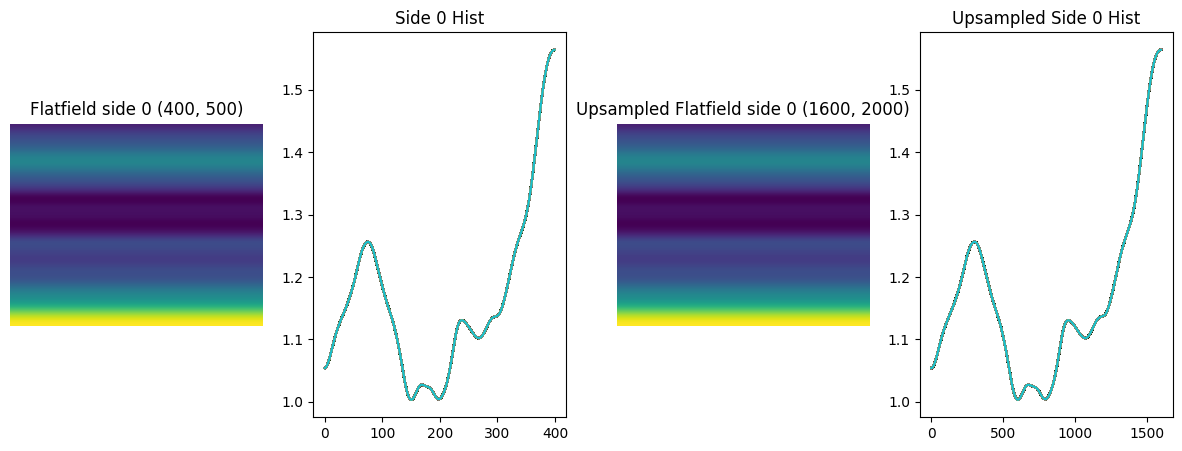

In [ ]:
from skimage.transform import resize

darkfield = np.full(flats['0']['median_flatfield'].shape, 105, dtype=np.uint8)
upsampled_median_flatfields = []
SCALE = 4

for side, flat_dict in flats.items():
    fig.suptitle(f'Side {side}', fontsize=16)
    
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    
    output_shape = tuple(SCALE * np.array(flat_dict['median_flatfield'].shape))
    
    upsampled_median_flatfield = resize(
        flat_dict['median_flatfield'],
        output_shape,
        order=4,
        mode='reflect',
        cval=0,
        clip=True,
        preserve_range=False,
        anti_aliasing=None,
    )
    
    upsampled_median_flatfields.append(upsampled_median_flatfield)
    
    # Plot the first image
    axs[0].imshow(flat_dict['median_flatfield'])
    axs[0].axis('off')  # Hide the axes
    axs[0].set_title(f"Flatfield side {side} {flat_dict['median_flatfield'].shape}")
    
    # Plot the third image
    axs[1].plot(flat_dict['median_flatfield'])
    # axs[0][2].axis('off')  # Hide the axes
    axs[1].set_title(f'Side {side} Hist')
    
    axs[2].imshow(upsampled_median_flatfield)
    axs[2].axis('off')  # Hide the axes
    axs[2].set_title(f"Upsampled Flatfield side {side} {upsampled_median_flatfield.shape}")
    
    # Plot the third image
    axs[3].plot(upsampled_median_flatfield)
    # axs[0][2].axis('off')  # Hide the axes
    axs[3].set_title(f'Upsampled Side {side} Hist')

    # Display the plot
    plt.show()

In [11]:
side_0_test_imgs = tiles_per_side['0'][98: 100, ...]
side_1_test_imgs = tiles_per_side['1'][98: 100, ...]

side_0_corrected_imgs = []

for idx in range(side_0_test_imgs.shape[0]):
    side_0_corrected_imgs.append(
        flatfield_correction(
            side_0_test_imgs[idx, ...],
            flatfield=flats['0']['median_flatfield'],
            darkfield=darkfield,
            baseline = None,#baseline,
        )
    )

side_1_corrected_imgs = []
    
for idx in range(side_1_test_imgs.shape[0]):
    
    side_1_corrected_imgs.append(
        flatfield_correction(
            side_1_test_imgs[idx, ...],
            flatfield=flats['1']['median_flatfield'],
            darkfield=darkfield,
            baseline = None,#baseline,
        )
    )


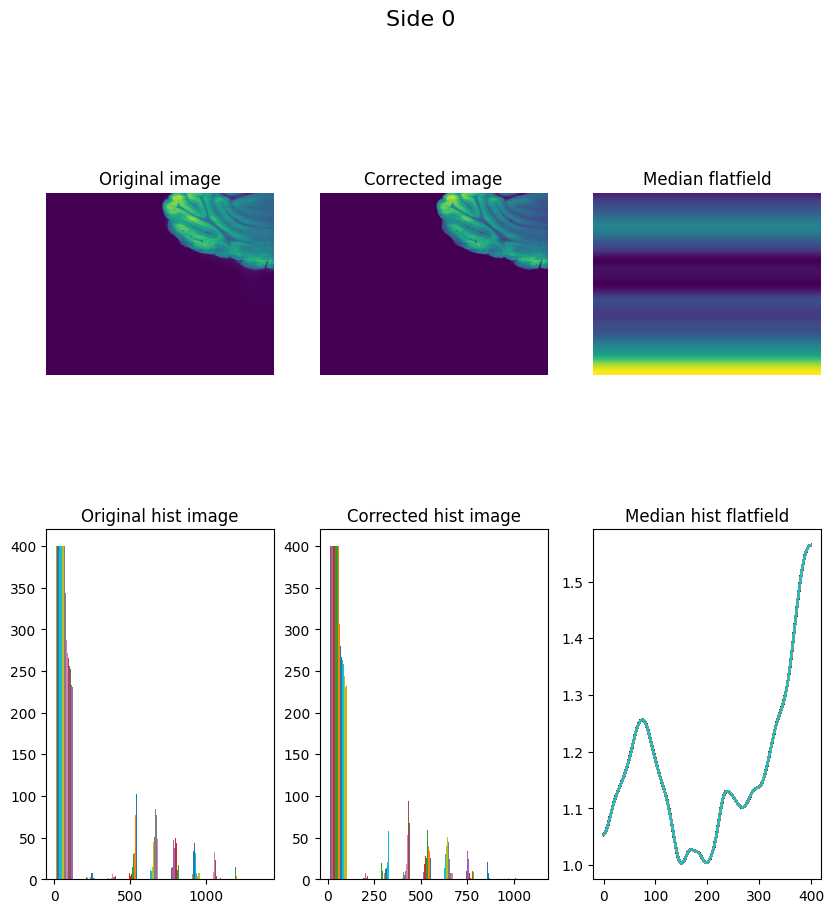

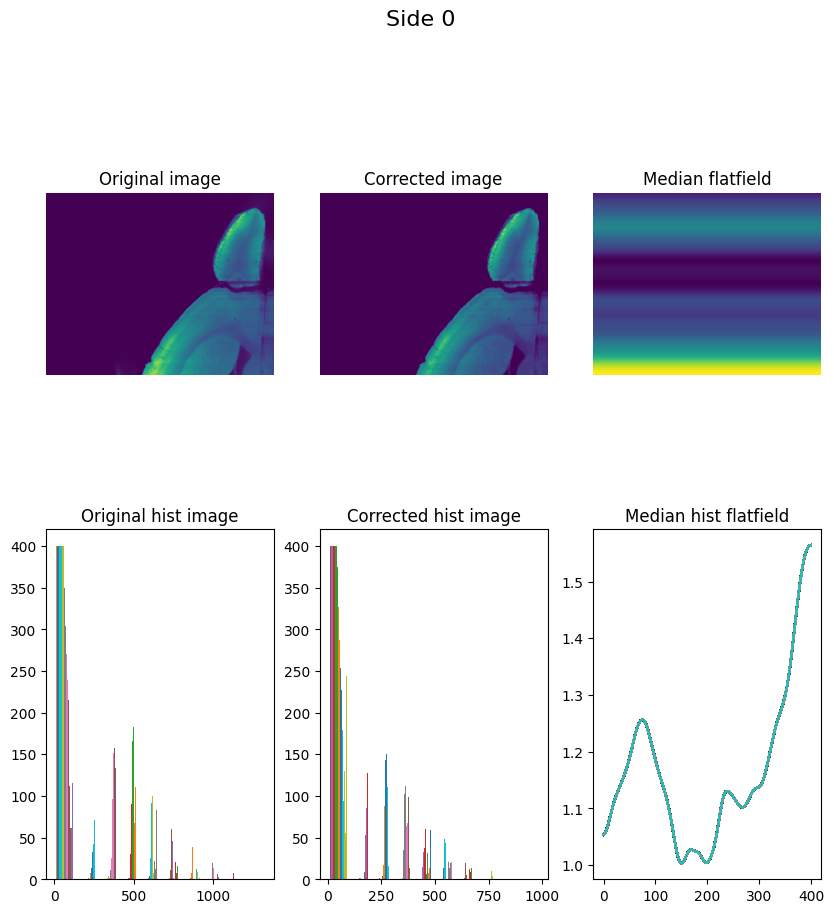

In [12]:
for idx in range(side_0_test_imgs.shape[0]):
    
    raw_img = side_0_test_imgs[idx, ...]
    corrected_img = side_0_corrected_imgs[idx]
    
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    
    fig.suptitle('Side 0', fontsize=16)
    
    
    # Plot the first image
    axs[0][0].imshow(raw_img)
    axs[0][0].axis('off')  # Hide the axes
    axs[0][0].set_title('Original image')

    # Plot the second image
    axs[0][1].imshow(corrected_img)
    axs[0][1].axis('off')  # Hide the axes
    axs[0][1].set_title('Corrected image')

    # Plot the third image
    axs[0][2].imshow(flats['0']['median_flatfield'])
    axs[0][2].axis('off')  # Hide the axes
    axs[0][2].set_title('Median flatfield')
    
    axs[1][0].hist(raw_img)
#     axs[1][0].axis('off')  # Hide the axes
    axs[1][0].set_title('Original hist image')

    # Plot the second image
    axs[1][1].hist(corrected_img)
#     axs[1][1].axis('off')  # Hide the axes
    axs[1][1].set_title('Corrected hist image')

    # Plot the third image
    axs[1][2].plot(flats['0']['median_flatfield'])
#     axs[1][2].axis('off')  # Hide the axes
    axs[1][2].set_title('Median hist flatfield')

    # Display the plot
    plt.show()

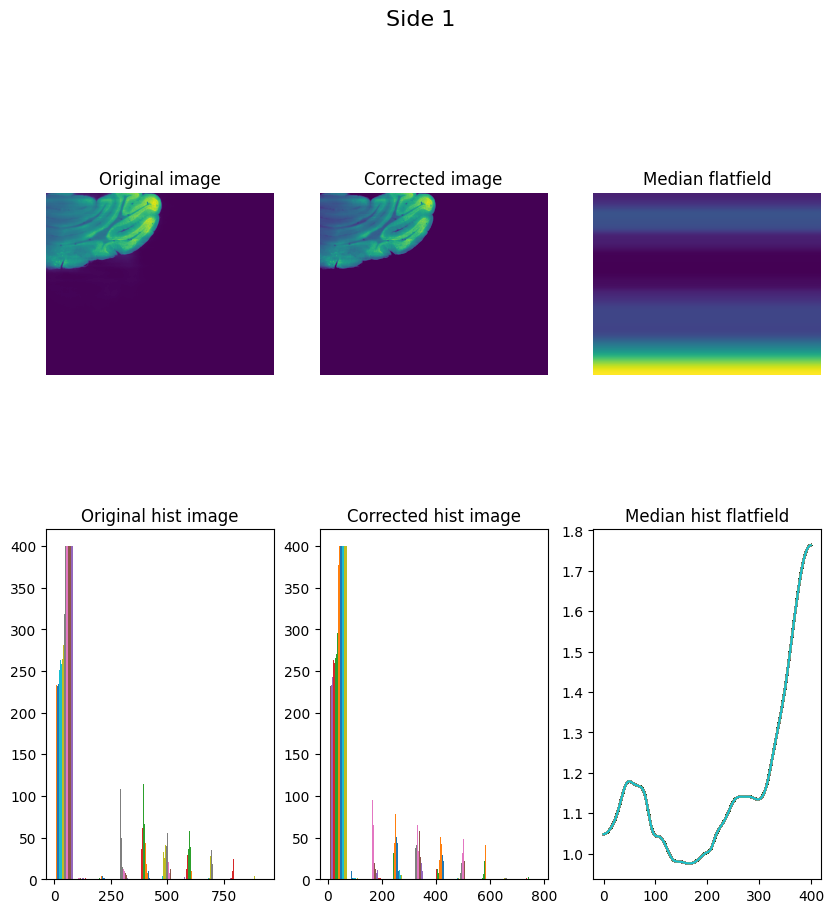

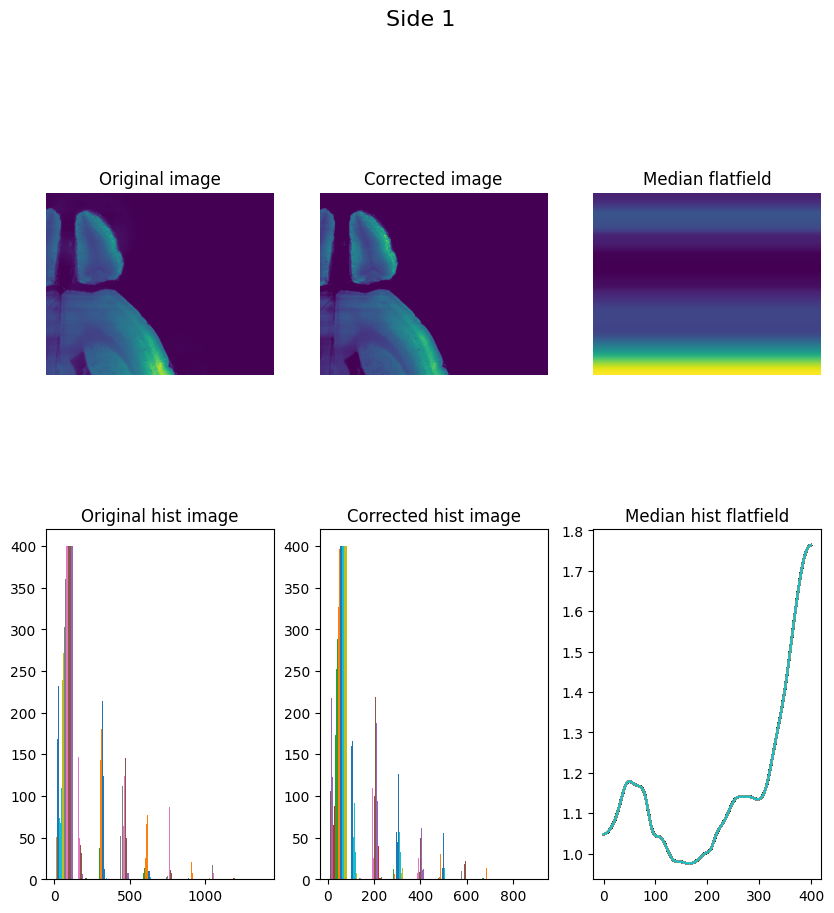

In [13]:
for idx in range(side_1_test_imgs.shape[0]):
    raw_img = side_1_test_imgs[idx, ...]
    corrected_img = side_1_corrected_imgs[idx]
    
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    fig.suptitle('Side 1', fontsize=16)
    
    # Plot the first image
    axs[0][0].imshow(raw_img)
    axs[0][0].axis('off')  # Hide the axes
    axs[0][0].set_title('Original image')

    # Plot the second image
    axs[0][1].imshow(corrected_img)
    axs[0][1].axis('off')  # Hide the axes
    axs[0][1].set_title('Corrected image')

    # Plot the third image
    axs[0][2].imshow(flats['1']['median_flatfield'])
    axs[0][2].axis('off')  # Hide the axes
    axs[0][2].set_title('Median flatfield')
    
    axs[1][0].hist(raw_img)
#     axs[1][0].axis('off')  # Hide the axes
    axs[1][0].set_title('Original hist image')

    # Plot the second image
    axs[1][1].hist(corrected_img)
#     axs[1][1].axis('off')  # Hide the axes
    axs[1][1].set_title('Corrected hist image')

    # Plot the third image
    axs[1][2].plot(flats['1']['median_flatfield'])
#     axs[1][2].axis('off')  # Hide the axes
    axs[1][2].set_title('Median hist flatfield')

    # Display the plot
    plt.show()

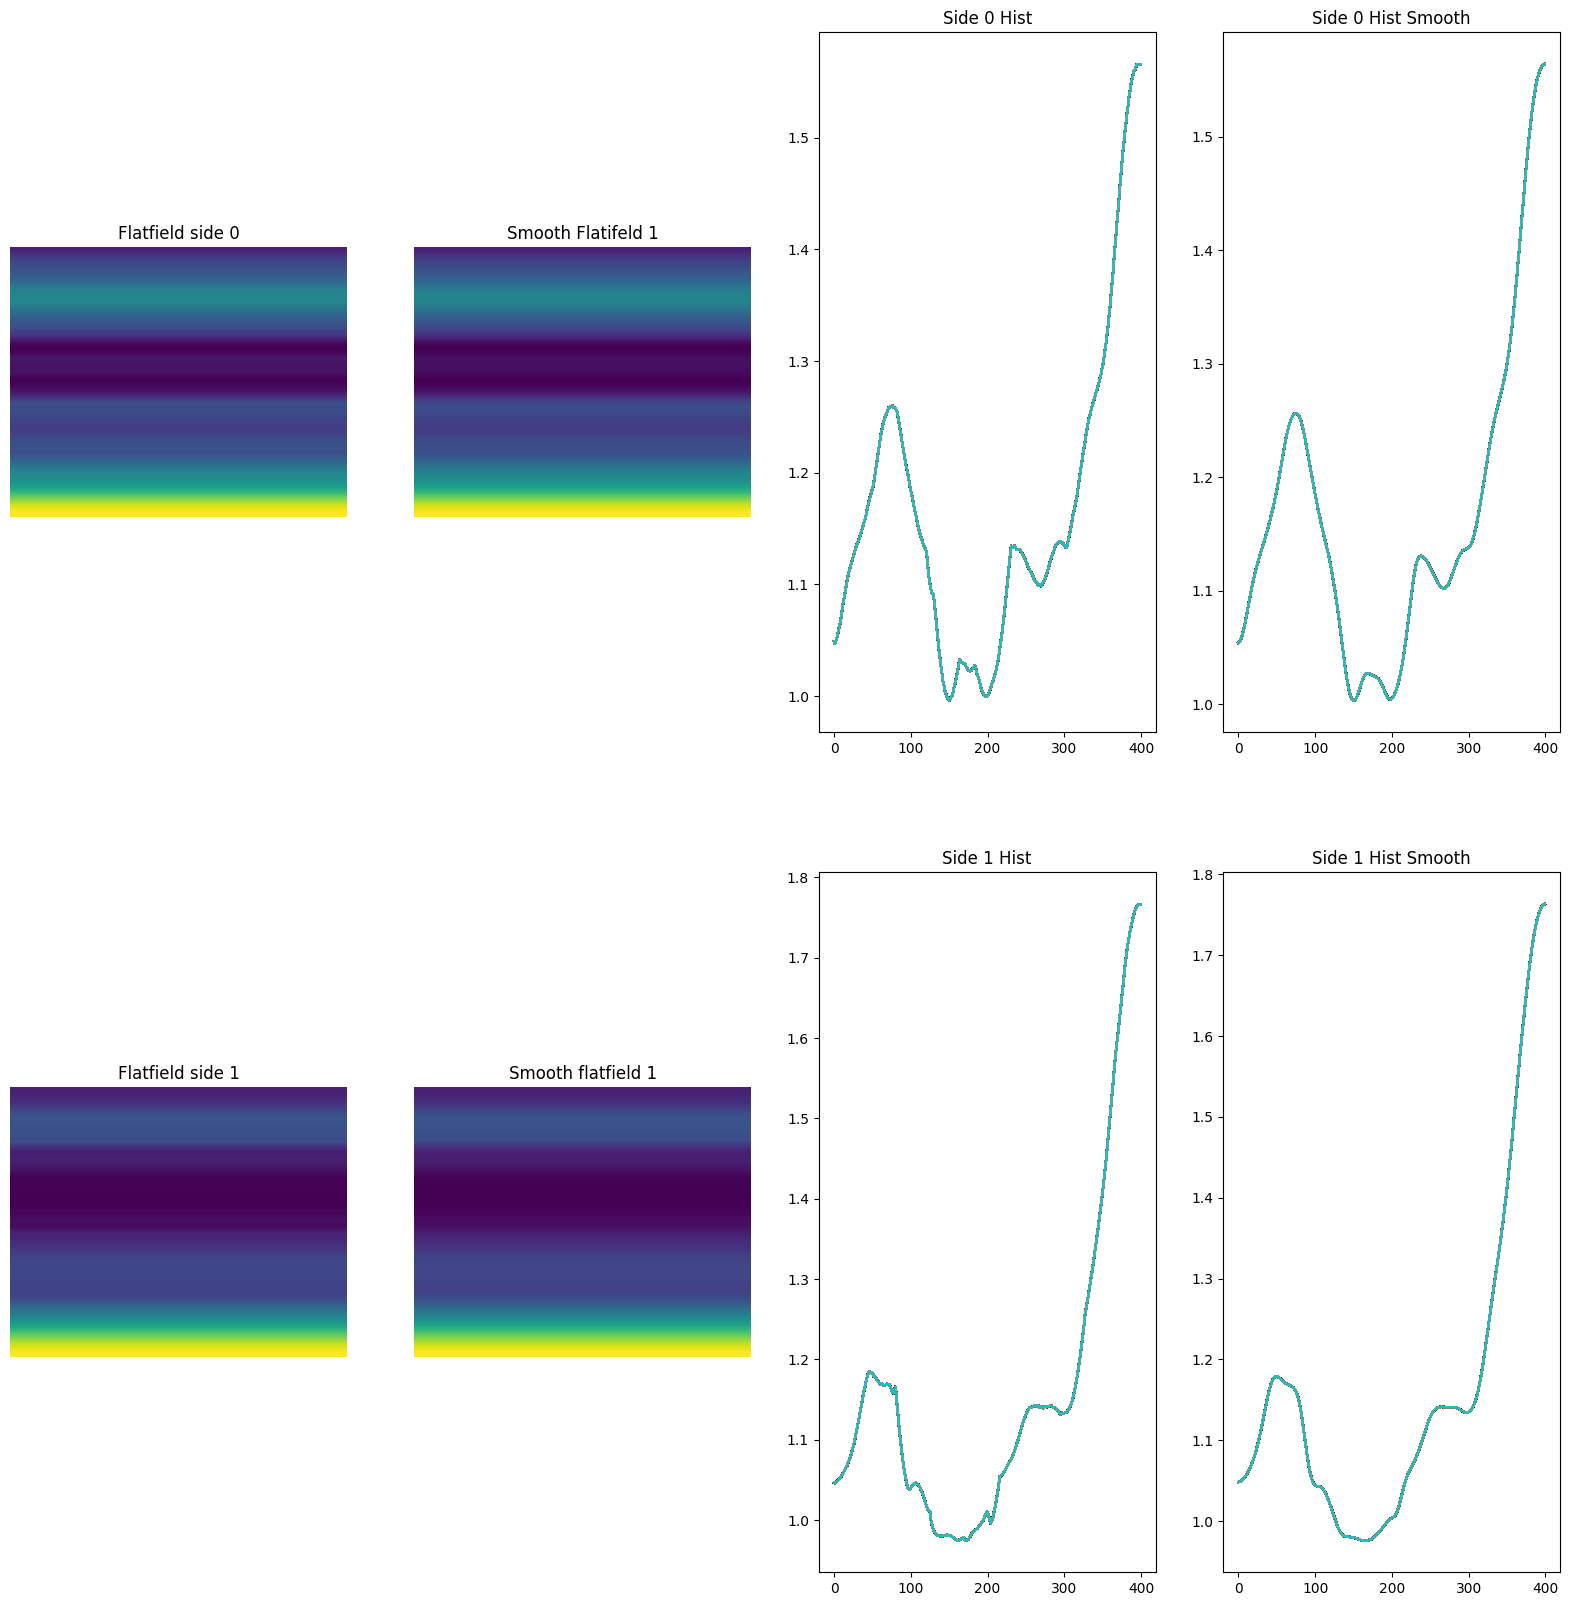

In [46]:
fig, axs = plt.subplots(2, 4, figsize=(20, 20))
# Plot the first image
axs[0][0].imshow(median_flatfield_0)
axs[0][0].axis('off')  # Hide the axes
axs[0][0].set_title('Flatfield side 0')

# Plot the second image
axs[0][1].imshow(smooth_median_flatfield_0)
axs[0][1].axis('off')  # Hide the axes
axs[0][1].set_title('Smooth Flatifeld 1')

# Plot the third image
axs[0][2].plot(median_flatfield_0)
# axs[0][2].axis('off')  # Hide the axes
axs[0][2].set_title('Side 0 Hist')

axs[0][3].plot(smooth_median_flatfield_0)
# axs[0][2].axis('off')  # Hide the axes
axs[0][3].set_title('Side 0 Hist Smooth')


axs[1][0].imshow(median_flatfield_1)
axs[1][0].axis('off')  # Hide the axes
axs[1][0].set_title('Flatfield side 1')

# Plot the second image
axs[1][1].imshow(smooth_median_flatfield_1)
axs[1][1].axis('off')  # Hide the axes
axs[1][1].set_title('Smooth flatfield 1')

# Plot the third image
axs[1][2].plot(median_flatfield_1)
# axs[0][2].axis('off')  # Hide the axes
axs[1][2].set_title('Side 1 Hist')

axs[1][3].plot(smooth_median_flatfield_1)
# axs[0][2].axis('off')  # Hide the axes
axs[1][3].set_title('Side 1 Hist Smooth')

# Display the plot
plt.show()